# Inicialización collab

In [1]:
# Importación de librerías
# Gestión de archivos y reporte
import os
import shutil
import logging
import yaml

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from PIL import Image

# Machine Learning
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargamos el dataframe desde el .CSV y definimos 'id' como índice
try:
    df_split = pd.read_csv('/content/drive/MyDrive/CV2-PlantVillage/dataframe_splitted.csv').set_index('id')
except FileNotFoundError:
    print(f"⚠️ Error: El archivo 'dataframe.csv' no se encontró en la ubicación actual: {os.getcwd()}")
    print("🚨 Se creará nuevamente al correr las celdas de 'Importación de imágenes' 🚨.")
    df_split = None
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")
    df_split = None

In [4]:
df_split.head()

,image_path,filename,class,group,tag,split
id,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train
1,Strawberry___healthy/,b8e9ed27-8e37-4214-9206-f8c0ef21cf4d___RS_HL 4...,Strawberry___healthy,Strawberry,healthy,test
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train


#### Descarga de dataset de Kaggle

In [5]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [6]:
# Ruta de acceso al dataset
ROOT_DIR = f'{DATASET_PATH}/plantvillage dataset/color'

# Dataset split

### Funciones necesarias

In [7]:
def create_ignore_function(df, train_label, filename_col='filename'):
    """
    Crea y devuelve la función 'ignore_files' que tiene acceso al DataFrame
    y sabe qué archivos mantener.
    """
    # Crea un conjunto (set) con los nombres de archivo que SÍ queremos copiar (ej: split == 'train')
    # Usa este conjunto para hacer la búsqueda de forma mucho más rápida
    files_to_keep = set(df[df['split'] == train_label][filename_col])
    #print(f"Archivos a mantener (split='{train_label}'): {files_to_keep}") # Debugging

    def ignore_files(current_dir, files_in_current_dir):
        """
        Función que será llamada por shutil.copytree.
        Decide qué archivos/directorios ignorar en el directorio actual.
        """
        ignore_list = []
        for item in files_in_current_dir:
            # Construye la ruta completa para verificar si es archivo o directorio
            full_path = os.path.join(current_dir, item)

            # Aplicar la lógica de ignorar SOLO los ARCHIVOS de la lista
            if os.path.isfile(full_path):
                # Si el nombre del archivo NO está en el conjunto de archivos a mantener,
                # entonces lo agrega a la lista de ignorados.
                if item not in files_to_keep:
                    # print(f"Ignorando archivo: {item} (en {current_dir})") # Debugging
                    ignore_list.append(item)

        # print(f"Directorio: {current_dir}, Ignorando: {ignore_list}") # Debugging
        return ignore_list

    # Devuelve la función 'ignore_files' configurada
    return ignore_files


In [8]:
import os, re

# Busca la carpeta raíz del dataset en el directorio donde fue descargado
def find_path(folder):
    match = re.search(fr"^(.*?)/{folder}/", DATASET_PATH)
    if match:
        prefix = match.group(1)
        path = os.path.join(prefix, f"{folder}/")
        return path
    else:
        print(f'No se ha podido encontrar la carpeta "{folder}" en {DATASET_PATH}')
        return None
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

## Split de archivos

In [9]:
# Guarda directorio del dataset dividido
path = find_path("plantvillage-dataset")
DATASETS_ROOT = path
SPLITTED_PATH = f"{path}splitted/" if path else None

No se ha podido encontrar la carpeta "plantvillage-dataset" en /kaggle/input/plantvillage-dataset


In [10]:
splits = df_split['split'].value_counts().index.tolist()
splits

['train', 'test']

In [11]:
verfication = True # Ejecuta el proceso de verificación (punto 2)

print(f"Se inicia proceso de copiado del dataset…")
total_files = len(df_split) # Total de archivos del dataset
print(f" - Total de archivos en el dataset: {total_files}")

# Realiza el proceso de copiado de archivos para cada split
succeeded_process = True
for split in splits:
    # Crea las rutas de origen y destino
    # (Ejemplo: 'train', 'test', 'valid')
    print(f"\n\nIniciando proceso para '{split}' split …")
    source_folder = f'{ROOT_DIR}/'
    destination_folder = f'{SPLITTED_PATH}{split}/'
    total_split = len(df_split[df_split['split'] == split]) # Total de archivos del split
    # Se omite verificación de existencia del dataset (porque se crea siempre desde cero)
    print(f"🔄 Procesando split '{split.upper()}' ({(total_split/total_files*100):.2f}):")
    print(f"  - Total de archivos a copiar: {total_split}")
    succeeded = False

    try:
        print(f"1. Creando estructura de subcarpetas:")
        # 1. Crea la función para ignorar específica para el split a procesar
        ignore_function = create_ignore_function(df_split, train_label=split, filename_col='filename')
        print(f"    ✔ Función de filtro creada para el split ")

        # 2. Con copytree copia todo el "árbol" de directorios (careptas y subcarpetas)
        # Fitrando con ignore_function todos aquellos archivos que no pertenecen al split deseado
        print(f"    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).")
        shutil.copytree(source_folder, destination_folder, ignore=ignore_function)
        print(f"    ✔ Proceso de copiado del split finalizado.")

        if verfication:
            # Verifica qué se haya copiado adecuadamente (opcional pero útil)
            print(f"2. Se inicia proceso de verificación…")
            copied_files = []
            for root, dirs, files_in_dest in os.walk(destination_folder):
                for name in files_in_dest:
                    copied_files.append(os.path.join(os.path.relpath(root, destination_folder), name).replace('\\', '/')) # Normalizar path
                    #print(f"  - {os.path.join(root, name)}") # Debuggin
            print(f"    ✔ Se crearon un total de {len(os.listdir(destination_folder))} carpetas (para las clases).")
            print(f"    ✔ Se copiaron un total de {len(copied_files)} archivos ({len(copied_files)/total_split*100:.2f}%)")
            # Agregar confirmación de igualdad cantidad split == copiados
            if len(copied_files) == total_split:
                print(f"✅ Se completó satisfactoriamente el subproceso de copiado para el split.\n")
                succeeded = True
            else:
                print(f"❌ Error: No se pudo copiar correctamente el split '{split.upper()}'\n")
                succeeded = False
        else:
            succeeded = True # Si la verificación está desactivada, se asume que el proceso fue exitoso

    except FileExistsError:
        print(f"Error: La carpeta de destino '{destination_folder}' ya existe.\n")
        pass
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}\n")

    succeeded_process *= succeeded # Actualiza el estado del proceso
    # (Sólo es 'True' si todos los splits se copian correctamente)

if succeeded_process:
    print("\n\n🌟 El proceso de copiado del dataset ha finalizado con éxito.\n")
else:
    print("\n\n🚫 No se pudo completar satisfactoriamente el proceso de copiado del dataset.\nVerificar que se haya completado la eliminación de las carpetas.\n")

Se inicia proceso de copiado del dataset…
 - Total de archivos en el dataset: 54305


Iniciando proceso para 'train' split …
🔄 Procesando split 'TRAIN' (80.00):
  - Total de archivos a copiar: 43444
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un total de 38 carpetas (para las clases).
    ✔ Se copiaron un total de 43444 archivos (100.00%)
✅ Se completó satisfactoriamente el subproceso de copiado para el split.



Iniciando proceso para 'test' split …
🔄 Procesando split 'TEST' (20.00):
  - Total de archivos a copiar: 10861
1. Creando estructura de subcarpetas:
    ✔ Función de filtro creada para el split 
    ∞ Copiando contenido del dataset (puede demorar hasta un minuto).
    ✔ Proceso de copiado del split finalizado.
2. Se inicia proceso de verificación…
    ✔ Se crearon un t

---

# Data Augmentation

In [12]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import random
import yaml
import shutil
from PIL import Image
import pandas as pd

### Funciones necesarias

In [13]:
def find_folder(path):
    return os.path.basename(os.path.dirname(path))

### Carga de datos almacenados

In [14]:
def dataset_already_exists(path_to_check: str) -> bool | None:
    """
    Verifica si el directorio especificado existe y está vacío.

    Args:
        path_to_check (str): Ruta del directorio a verificar.

    Returns:
        bool: True si el directorio existe y está vacío, False en caso contrario.
    """
    if not os.path.exists(path_to_check):
        # El directorio no existe -> Crea el directorio
        #print(f"☑️ El directorio no existe, aún no ha sido creado:\n > {path_to_check}") # Debugging
        return False # No realiza ninguna acción
    else:
        # Verificar si el directorio está vacío
        try:
            # Explora el contenido del directorio
            content = os.listdir(path_to_check)
            #print(content) # Debugging

            # Si el directorio está vacío, se puede eliminar directamente
            #       -> Elimina sin confirmación
            if not content:
                os.rmdir(path_to_check) # Elimina el directorio vacío
                print(f"☑️ El directorio estaba vacío y se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False

            # Si el directorio contiene sólo archivos ocultos (de sistema)
            #       -> Elimina sin confirmación
            elif all([file.startswith('.') for file in content]):
                shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                print(f"☑️ El directorio sólo contenía archivos ocutlos, por lo que se ha eliminado de forma automática:\n > {path_to_check}\n")
                return False

            # Si hay archivos visibles en el directorio (dataset ya existe)
            #       -> Solicita permiso para eliminarlos
            else:
                # Input de confirmación del usuario
                confirmacion = input(f"⚠️ El directorio especificado ya existe y contiene archivos. ¿Deseas eliminar todo su contenido y el directorio en sí? [Y/N]: '{path_to_check}'").strip().lower()
                # Verifica la respuesta del usuario
                if confirmacion == 'y':
                    shutil.rmtree(path_to_check) # Elimina el directorio y su contenido
                    print(f"✅ El directorio y su contenido han sido eliminados exitosamente:\n > {path_to_check}\n")
                    return False
                else:
                    print(f"⛔️ La eliminación del directorio ha sido denegada por el usuario:\n  > {path_to_check}")
                    return True

        except OSError as e:
            print(f"❌ Error al eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None
        except Exception as e:
            print(f"‼️ Ocurrió un error inesperado al intentar eliminar el directorio vacío en {path_to_check}: {e}\n")
            return None



In [15]:
# Carga de imagenes en memoria y visualización
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    # if index < 0 or index >= len(data):
    #     print("Índice fuera de rango.")
    #     return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

In [16]:
# Carga de imagenes en memoria y visualización
def load_image_idx(data, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    # if index < 0 or index >= len(data):
    #     print("Índice fuera de rango.")
    #     return None

    row = data
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

----

## Transformaciones

In [17]:
# 1. Define las transformaciones de Albumentations
transform = A.Compose([
    # Espaciales
    A.Rotate(limit=180, p=0.5),          # Rotación aleatoria hasta 180 grados con probabilidad 0.5
    A.HorizontalFlip(p=0.5),            # Volteo horizontal con probabilidad 0.5
    A.VerticalFlip(p=0.5),              # Volteo vertical con probabilidad 0.5
    A.RandomScale(scale_limit=0.1, p=0.3),      # Escalado aleatorio con un límite de 30%
    A.RandomCrop(width=200, height=200, p=0.3), # Recorte aleatorio a 200x200 (original 256px)
    # Visuales
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3), # Ajuste de brillo y contraste aleatorio
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3), # Ajuste de tono, saturación y valor
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),   # Desenfoque Gaussiano
])

In [18]:
# 2. Transformaciones alternativas (más agresivas) para clases minoritarias
proba_mult = 2
scaler = 1.5
transform2 = A.Compose([
    A.Rotate(limit=180, p=0.5*proba_mult),          # Rotación aleatoria hasta 180 grados con probabilidad 0.5
    A.HorizontalFlip(p=0.5*proba_mult),            # Volteo horizontal con probabilidad 0.5
    A.VerticalFlip(p=0.5*proba_mult),              # Volteo vertical con probabilidad 0.5
    A.RandomBrightnessContrast(brightness_limit=0.2*scaler, contrast_limit=0.2*scaler, p=0.3*proba_mult), # Ajuste de brillo y contraste aleatorio
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30*scaler, val_shift_limit=20*scaler, p=0.3*proba_mult), # Ajuste de tono, saturación y valor
    A.RandomCrop(width=200, height=200, p=0.3*proba_mult), # Recorte aleatorio a 200x200
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),   # Desenfoque Gaussiano
    A.RandomScale(scale_limit=0.1, p=0.3*proba_mult),      # Escalado aleatorio con un límite de 30%
    A.CLAHE(clip_limit=2.0, p=0.8),             # Ecualización CLAHE
    # Se agrega CLAHE para compensar algunos valores extremos (brillo, contraste) fruto del 'scaler' y el aumento de la probabilidad
])

In [19]:
def apply_transformations(original_image, algo: int = 1) -> np.ndarray:
    """
    Applies transformations to an input image using Albumentations.

    Args:
        original_image (PIL.Image.Image): The original image to transform.
        algo (int, optional): The transformation strategy to use. Defaults to 1.
            - 1: Applies the first set of transformations (`transform`).
            - 2: Applies the second set of transformations (`transform2`).

    Returns:
        numpy.ndarray: The transformed image as a NumPy array.
    """
    # Convertir la imagen original a un array NumPy para la transformación
    original_image_array = np.array(original_image)

    algo_opt = [1, 2]
    # Aplicar las transformaciones
    if algo == algo_opt[0]:
        transformed = transform(image=original_image_array)
    elif algo == algo_opt[1]:
        transformed = transform2(image=original_image_array)
    else:
        print("Debe seleccionar entre las siguientes opciones:")
        for opt in algo_opt:
            print(f'Opción: `algo={opt}`')
            if opt == algo_opt[0]:
                print(transform)
            elif opt == algo_opt[1]:
                print(transform2)
            print()
    return transformed['image']

----
## Procesamiento del dataset

### Funciones necesarias

In [20]:
import humanize

# Traducir humanize al español
try:
    humanize.i18n.activate("es")
except FileNotFoundError:
    print("Paquete de idioma español para humanize no encontrado, usando inglés.")
    humanize.i18n.activate("en_US") # Fallback a inglés

In [21]:
import re
import numpy as np
#from collections import defaultdict

def cluster_by_count_distribution(data_string, std_dev_multiplier=1.0, verbose = True):
    """
    Agrupa categorías basándose en la distribución de sus conteos.

    Agrupa elementos con conteos similares utilizando diferencias logarítmicas.
    Identifica valores atípicos con conteos significativamente diferentes como clústeres separados.

    Args:
        data_string (str): Una cadena multilínea donde cada línea contiene
                           un nombre de categoría y su conteo, separados por espacios.
        std_dev_multiplier (float): Multiplicador para la desviación estándar utilizado
                                    en el cálculo del umbral para identificar
                                    rupturas de clúster. Valores más altos generan menos
                                    clústeres más grandes. Por defecto es 1.0.

    Returns:
        list: Una lista de clústeres, donde cada clúster es una lista de
              tuplas (nombre_categoria, conteo).
              Devuelve una lista vacía si falla el análisis o no se encuentra ningún dato.
    """
    # --- 1. Analizar los datos de entrada ---
    data = {}
    # Expresión regular para capturar el nombre de la categoría (que puede contener espacios/caracteres especiales)
    # y el conteo al final
    # Maneja posibles espacios adicionales.
    pattern = re.compile(r'^(.*?)\s+(\d+)$')
    lines = data_string.strip().split('\n')

    if not lines or (len(lines) == 1 and not lines[0].strip()):
        print("Error: La cadena de datos de entrada está vacía o no es válida.")
        return []

    for line in lines:
        line = line.strip()
        if not line:
            continue  # Saltar líneas vacías
        match = pattern.match(line)
        if match:
            # El grupo 1 captura todo antes del último bloque de dígitos
            name = match.group(1).strip()
            # El grupo 2 captura el último bloque de dígitos
            count = int(match.group(2))
            data[name] = count
        else:
            print(f"Advertencia: No se pudo analizar la línea: '{line}'")

    if not data:
        print("Error: No se analizaron datos válidos de la cadena de entrada.")
        return []

    # --- 2. Ordenar los datos ---
    # Convertir a una lista de tuplas y ordenar por conteo en orden descendente
    # Esto facilita la comparación de elementos consecutivos.
    sorted_items = sorted(data.items(), key=lambda item: item[1], reverse=True)

    # Manejar el caso con solo un elemento
    if len(sorted_items) <= 1:
        print("Solo se encontró un punto de datos, devolviéndolo como un único clúster.")
        return [sorted_items]

    # --- 3. Calcular diferencias logarítmicas ---
    # Extraer los conteos en un array de numpy
    counts = np.array([item[1] for item in sorted_items])

    # Calcular el logaritmo de los conteos. La transformación logarítmica ayuda a normalizar
    # grandes diferencias y centrarse en cambios relativos.
    # Se agrega un pequeño epsilon para evitar log(0) si los conteos pueden ser cero.
    epsilon = 1e-9
    log_counts = np.log(counts + epsilon)

    # Calcular las diferencias entre los logaritmos consecutivos de los conteos.
    # Dado que los datos están ordenados de forma descendente, una gran diferencia positiva aquí
    # indica una gran caída en el valor del conteo.
    # diff[i] = log_counts[i] - log_counts[i+1]
    log_diffs = -np.diff(log_counts)

    # --- 4. Determinar rupturas de clúster ---
    # Identificar saltos significativos en los conteos logarítmicos utilizando un umbral basado en
    # la media y la desviación estándar de las diferencias logarítmicas.
    # Las diferencias mayores que el umbral sugieren un punto de ruptura para un nuevo clúster.
    if len(log_diffs) > 0:
        mean_log_diff = np.mean(log_diffs)
        std_log_diff = np.std(log_diffs)
        # Establecer el umbral: media + multiplicador * desviación estándar
        # Ajustar el multiplicador para cambiar la sensibilidad (mayor = menos sensible)
        threshold = mean_log_diff + std_dev_multiplier * std_log_diff
        if verbose:
            print(f"- Diferencias logarítmicas: {np.round(log_diffs, 2)}")
            print(f"- Diferencia logarítmica media: {mean_log_diff:.2f}")
            print(f"- Desviación estándar de las diferencias logarítmicas: {std_log_diff:.2f}")
            print(f"- Umbral (Media + {std_dev_multiplier:.1f}*SD): {threshold:.2f}")

        # Encontrar índices *donde* la diferencia excede el umbral.
        # Esto indica una ruptura *después* de este índice en la lista ordenada.
        # np.where devuelve una tupla de arrays, necesitamos el primer array.
        break_after_indices = np.where(log_diffs >= threshold)[0]
        # El nuevo clúster comienza en el índice *siguiente*.
        break_start_indices = break_after_indices + 1

        if verbose:
            print(f"- Puntos de quiembre detectados después de los elementos en los índices: {break_after_indices}")
            print(f"- Los nuevos clústeres comienzan en los índices: {break_start_indices}")
    else:
        # No hay diferencias para calcular si hay <= 1 elemento
        break_start_indices = []
        print("No hay suficientes puntos de datos para calcular diferencias.")

    # --- 5. Agrupar en clústeres ---
    clusters = []
    start_index = 0
    # Iterar a través de los puntos de ruptura identificados (donde comienzan nuevos clústeres)
    for break_idx in break_start_indices:
        # Agregar el segmento antes de la ruptura como un clúster
        clusters.append(sorted_items[start_index:break_idx])
        # Actualizar el índice de inicio para el próximo clúster
        start_index = break_idx
    # Agregar los elementos restantes (desde el último punto de ruptura hasta el final) como el clúster final
    clusters.append(sorted_items[start_index:])

    return clusters

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_clusters(df, target, found_clusters):
    df_graph = df.copy()

    # 1. Crear un mapeo del nombre de la categoría al ID del clúster
    category_to_cluster_id = {}
    for cluster_id, cluster_list in enumerate(found_clusters):
        for category_name, _ in cluster_list:  # Solo necesitamos el nombre aquí
            category_to_cluster_id[category_name] = cluster_id  # Asignar 0, 1, 2...

    # 2. Usar este mapeo para crear la columna 'cluster' en df_graph
    df_graph['cluster'] = df_graph[target].map(category_to_cluster_id)


    # Opcional: Convertir los IDs de clúster a tipo string para etiquetas de leyenda más claras
    n_clusters = len(df_graph['cluster'].unique())
    # Map numerical cluster IDs to textual labels (e.g., "Cluster 1", "Cluster 2", ...)
    cluster_id_to_text = {cluster_id: f"Cluster {cluster_id + 1}" for cluster_id in range(n_clusters)}
    df_graph['cluster'] = df_graph['cluster'].map(cluster_id_to_text)

    # Sort the clusters in descending order based on their IDs
    df_graph['cluster'] = pd.Categorical(df_graph['cluster'],
                                        categories=[f"Cluster {i + 1}" for i in range(n_clusters)],
                                        ordered=True)

    # Obtener el conteo de cada clase
    class_counts = df_graph[target].value_counts().sort_values(ascending=False)

    # Obtener la lista ordenada de clases basada en el conteo
    ordered_classes_by_count = class_counts.index.tolist()

    # Configurar el tamaño de la figura
    plt.figure(figsize=(15, 10))

    # Crear un gráfico de barras (usando el argumento data= para mayor claridad)
    sns.countplot(y=target, order=ordered_classes_by_count, hue='cluster',
                data=df_graph, palette="Spectral", dodge=False)

    plt.title("Gráfico de barras de la distribución de clases objetivo coloreado por clústeres (basado en el conteo)")
    plt.ylabel("Clases objetivo")
    plt.xlabel("Conteo")
    plt.legend(title='ID del clúster')

    plt.tight_layout()
    plt.show()

In [23]:
def filter_classes(df, target, range: tuple = (0,None)):
    lim_min, lim_max = range
    counts = df[target].value_counts()
    if lim_min == None:
        lim_min  = 0
    if lim_max == None:
        lim_max  = counts.max()
    #print("Limites:", lim_min, lim_max)

    selection = []
    for idx, count in enumerate(counts):
        if lim_min < count <= lim_max:
            clase = counts.index[idx]
            selection.append(clase)
    return selection

In [24]:
def gen_rnd_id():
    """
        Genera un número aleatorio de 6 cífras que se usará para diferenciar imagenes procesados de las originales
    """
    rnd_seed = round(time.time() * 1e10) # Use clock as seed generator
    random.seed(rnd_seed)  # Set this value as a new seed (assure better randomization)
    sampled_numbers = random.sample(range(int(1e6)), 1)  # Generates a random number
    return str(sampled_numbers[0]).zfill(6)

In [25]:
def numoji(numero):
  """
  Convierte un número entero del 1 al 10 a su emoji correspondiente.

  Args:
    numero: Un entero entre 1 y 10.

  Returns:
    Un string con el emoji correspondiente al número, o "0️⃣" si el número
    está fuera del rango.
  """
  if 1 <= numero <= 10:
    emoji_map = {
        1: "1️⃣",
        2: "2️⃣",
        3: "3️⃣",
        4: "4️⃣",
        5: "5️⃣",
        6: "6️⃣",
        7: "7️⃣",
        8: "8️⃣",
        9: "9️⃣",
        10: "🔟"
    }
    return emoji_map[numero]
  else:
    return "*️⃣"

In [26]:
def show_test_mode_alert(spacer2):
    print()
    print(spacer2,("⚠️"*31))
    print(spacer2,"⚠️",(" "*46),"⚠️")
    print(f"{spacer2} ⚠️      🚨     MODO TESTING ACTIVADO      🚨       ⚠️")
    print(spacer2,"⚠️",(" "*46),"⚠️")
    print(f"{spacer2} ⚠️ (+) Se omite la apertura de imágenes           ⚠️")
    print(f"{spacer2} ⚠️ (+) Se omite las creación de transformaciones  ⚠️")
    print(spacer2,"⚠️",(" "*46),"⚠️")
    print(f"{spacer2} ⚠️    ESTE PROCESO NO GENERARÁ ARCHIVOS REALES    ⚠️")
    print(spacer2,"⚠️",(" "*46),"⚠️")
    print(spacer2,("⚠️"*31))
    print()

## Creación de directorios y estructuras de datos

In [27]:
# Se ha definido una nueva constante con la ubicación del dataset aumentado (será almacenadad en YAML)
AUG_PATH = SPLITTED_PATH

Luego, se aplican las transformaciones para aumentación de datos a la copia del dataset.

In [28]:
# Agrega columnas para indicar procesamiento
## original -> imagen sin transofrmaciones
## augmented -> existen aumentaciones derivadas
df_split['augmented'] = False
df_split['is_original'] = True

# Crea un nuevo dataframe para gesitonar el procesamiento
process_split = df_split[df_split['split']=='train'].copy()
process_split

,image_path,filename,class,group,tag,split,augmented,is_original
id,,,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train,False,True
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
5,Strawberry___healthy/,4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True
...,...,...,...,...,...,...,...,...
54299,Soybean___healthy/,39d15a45-c9f2-4933-b31e-fde13e0141b1___RS_HL 2...,Soybean___healthy,Soybean,healthy,train,False,True
54300,Soybean___healthy/,57c18b39-2a33-471f-91eb-a9ba4ddabc7b___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True
54301,Soybean___healthy/,4fdc663e-a8ea-4d8a-801b-ef18ad192661___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True


In [29]:
# Crea una columna 'ref' que apunta al id de la imagen original
process_split['ref'] = process_split.index
process_split

,image_path,filename,class,group,tag,split,augmented,is_original,ref
id,,,,,,,,,
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,0
2,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,2
3,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train,False,True,3
4,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,4
5,Strawberry___healthy/,4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,5
...,...,...,...,...,...,...,...,...,...
54299,Soybean___healthy/,39d15a45-c9f2-4933-b31e-fde13e0141b1___RS_HL 2...,Soybean___healthy,Soybean,healthy,train,False,True,54299
54300,Soybean___healthy/,57c18b39-2a33-471f-91eb-a9ba4ddabc7b___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True,54300
54301,Soybean___healthy/,4fdc663e-a8ea-4d8a-801b-ef18ad192661___RS_HL 6...,Soybean___healthy,Soybean,healthy,train,False,True,54301


## Estrategia de aumentación

In [30]:
# Se define el feature a partir del cual se aplicarán las aumentaciones
target = 'class' # class / group
#data = df.copy()
data = process_split.copy()
#data = df_augmented.copy()
#data = processed_split.copy()

In [31]:
# Resumen distribucion por grupo
print(f"Conteo por '{target}':")
counts = data[target].value_counts()
for class_name, count in counts.items():
    print(f" - {class_name}: {count}")

Conteo por 'class':
 - Orange___Haunglongbing_(Citrus_greening): 4405
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286
 - Soybean___healthy: 4072
 - Peach___Bacterial_spot: 1837
 - Tomato___Bacterial_spot: 1702
 - Tomato___Late_blight: 1527
 - Squash___Powdery_mildew: 1468
 - Tomato___Septoria_leaf_spot: 1417
 - Tomato___Spider_mites Two-spotted_spider_mite: 1341
 - Apple___healthy: 1316
 - Tomato___healthy: 1273
 - Blueberry___healthy: 1202
 - Pepper,_bell___healthy: 1182
 - Tomato___Target_Spot: 1123
 - Grape___Esca_(Black_Measles): 1106
 - Corn_(maize)___Common_rust_: 953
 - Grape___Black_rot: 944
 - Corn_(maize)___healthy: 930
 - Strawberry___Leaf_scorch: 887
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 861
 - Cherry_(including_sour)___Powdery_mildew: 842
 - Potato___Early_blight: 800
 - Potato___Late_blight: 800
 - Tomato___Early_blight: 800
 - Pepper,_bell___Bacterial_spot: 798
 - Corn_(maize)___Northern_Leaf_Blight: 788
 - Tomato___Leaf_Mold: 762
 - Cherry_(including_sour)___he

In [32]:
def find_clusters(data):
    # Convierte el diccionario a una cadena multilínea
    data_string = dict(data.value_counts())
    data_string = "\n".join(f"{key} {value}" for key, value in data_string.items())

    # --- Ejecuta la función de agrupamiento ---
    # Puedes ajustar el std_dev_multiplier (por ejemplo, 0.5, 1.0, 1.5)
    # para hacer que el agrupamiento sea más o menos sensible a las brechas de conteo.
    # Un valor más bajo podría crear más clústeres.
    multiplier = 0.15 # 0.5 / 0.25 / 0.1 proba distintos valores
    found_clusters = cluster_by_count_distribution(data_string, std_dev_multiplier=multiplier,verbose=False)

    # --- Muestra los resultados ---
    print(f"Clústeres identificados:")
    print(f" · Multiplicador Desviación Estándar {multiplier}\n")
    if found_clusters:
        for i, cluster in enumerate(found_clusters):
            # Filtrar clústeres potencialmente vacíos si el corte resultó en uno
            if cluster:
                print(f"Clúster {i + 1}:")
                # Obtener conteos para calcular el rango (opcional para mostrar)
                cluster_counts = [count for _, count in cluster]
                print(f"  (Rango de conteo: {min(cluster_counts)} - {max(cluster_counts)})")
                # Imprimir elementos en el clúster
                for name, count in cluster:
                    print(f"  - {name}: {count}")
                print()
        return found_clusters
    else:
        print("No se identificaron clústeres.")
        return None

found_clusters = find_clusters(data[target])

Clústeres identificados:
 · Multiplicador Desviación Estándar 0.15

Clúster 1:
  (Rango de conteo: 4072 - 4405)
  - Orange___Haunglongbing_(Citrus_greening): 4405
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286
  - Soybean___healthy: 4072

Clúster 2:
  (Rango de conteo: 1106 - 1837)
  - Peach___Bacterial_spot: 1837
  - Tomato___Bacterial_spot: 1702
  - Tomato___Late_blight: 1527
  - Squash___Powdery_mildew: 1468
  - Tomato___Septoria_leaf_spot: 1417
  - Tomato___Spider_mites Two-spotted_spider_mite: 1341
  - Apple___healthy: 1316
  - Tomato___healthy: 1273
  - Blueberry___healthy: 1202
  - Pepper,_bell___healthy: 1182
  - Tomato___Target_Spot: 1123
  - Grape___Esca_(Black_Measles): 1106

Clúster 3:
  (Rango de conteo: 683 - 953)
  - Corn_(maize)___Common_rust_: 953
  - Grape___Black_rot: 944
  - Corn_(maize)___healthy: 930
  - Strawberry___Leaf_scorch: 887
  - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 861
  - Cherry_(including_sour)___Powdery_mildew: 842
  - Potato___Early_blight: 8

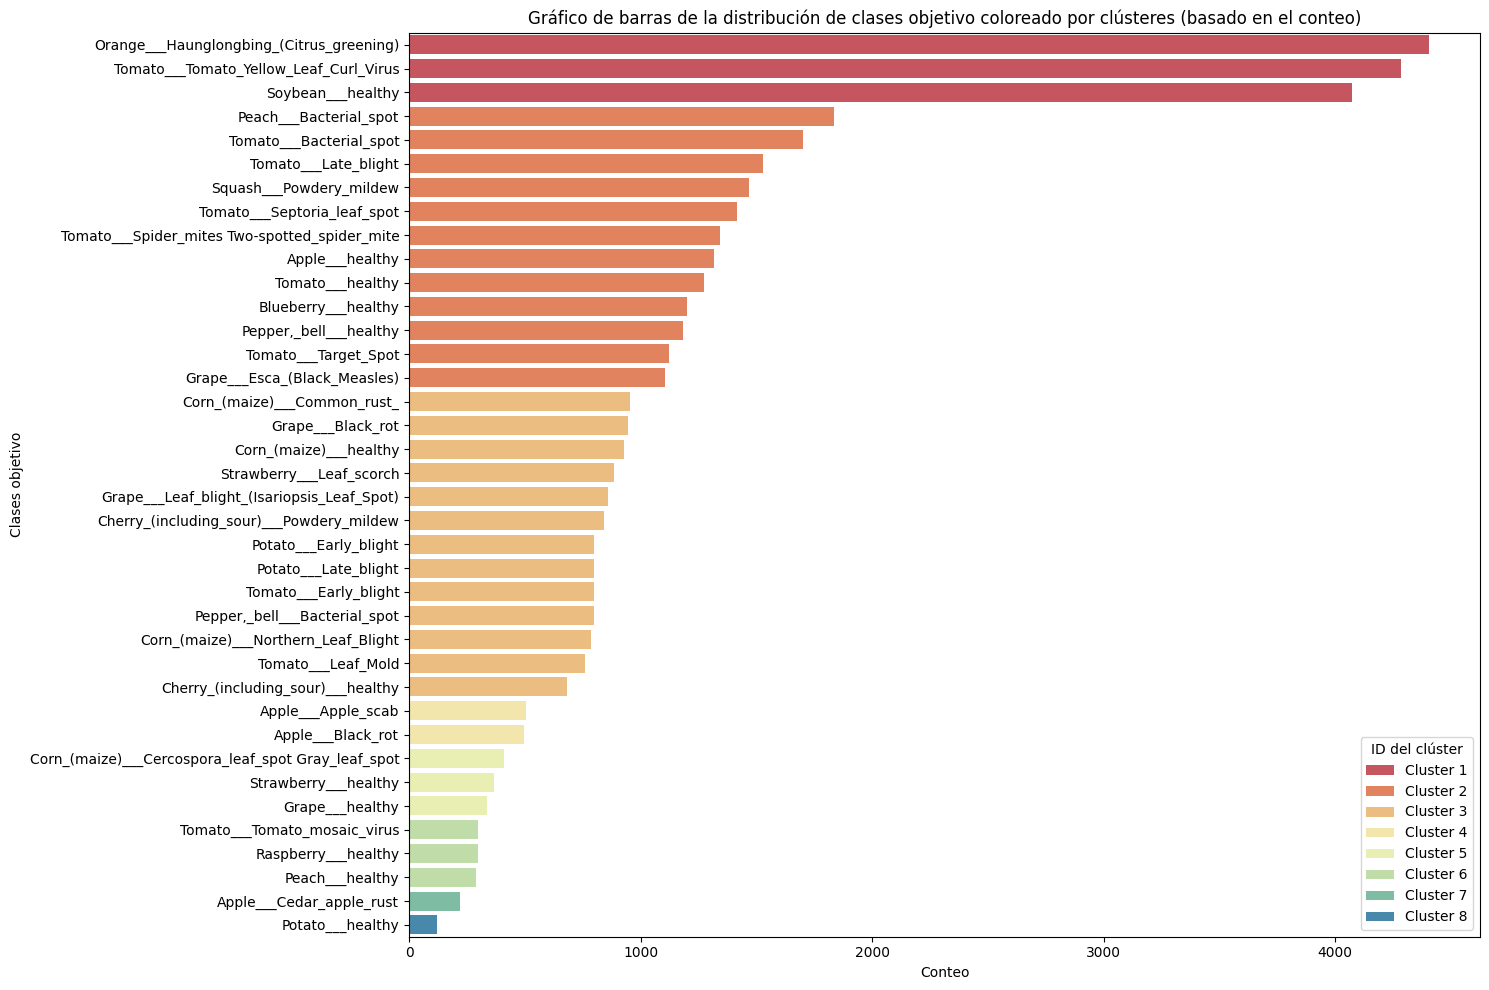

In [33]:
plot_clusters(data, target, found_clusters)

Se identifican las siguientes distribuciones:
- **Para target `class`:**
    1. **Clase mayoritaria** 'Soybean___healthy' con ~4.5k
    1. Grupo 1 con rango de > 4k *(3 clases)*
    1. Grupo 2 con rango de ~1k - 2k ***ascendente***
    1. Grupo 3 con rango de ~500 - 1k
        1. Mitad sueprior ***ascendente*** con rango de >800k
        1. Mitad inferior ***constante*** ~800 *(8 clases)*
    1. Grupo 4 con rango de ~400 - 500 *(2 clases)*
    1. Grupo 5 con rango de ~400 *(3 clases)* ***ascendente***
    1. Grupo 6 con rango de ~300 *(3 clases)* ***constante***
    1. Clase aislada de ~200
    1. **Clase minoritaria** 'Potato___healthy' con ~100

- **Para target `group`:**
    1. **Clase mayoritaria** 'Tomato' con ~14.5k
    1. Grupo 1 con rango de ~4k *(2 clases)*
    1. Grupo 2 con rango de ~3k *(2 clases)*
    1. Grupo 3 con rango de ~2k *(4 clases)*
    1. Grupo 4 con rango de ~1.5k *(2 clases)*
    1. Grupo 5 con rango de ~1.2k *(2 clases)*
    1. **Clase minoritaria** 'Raspberry' con ~300

**Estrategia 1:**
- Se dejan sin procesar los primeros 3 grupos *(>4k)* **⇢ =**
- Para los grupos 1 y 2 *(2k–4k)* se aplica **⇢ x2**
- Para los grupos 3 a 6 *(500–2k)* se aplica **⇢ x3**
- Para la clase minotirtaria *(<500)* se aplica **⇢ x6**

In [34]:
# ESTRATEGIA PARA AUMENTACIÓN POR 'GRUPO' (estrategia 1)
# Clases a las que se le aplicará aumentación de datos
# Entre 4000 y 2000
group1 = {
    'classes': filter_classes(df_split,target,(2000,4000)),
    'increase': 2 # 2x data augmentation (original + transf)
}
# Menores a 2000
group2 = {
    'classes': filter_classes(df_split,target,(500,2000)),
    'increase': 3 # 3x data augmentation (original +  2 transf)
}

# Clase mínima (Raspberry)
group3 = {
    'classes': filter_classes(df_split,target,(0,500)),
    'increase': 6 # 6x data augmentation (original +  5 transf)
}

estrategy1 = [group1, group2, group3]

**Estrategia 2:**

A diferencia de la estrategia anterior, además de la aumentanción, se aplicará la técnica de  submuestreo (*undersampling*) para las clases mayoritarias.

Se intentará balancear todas las clases entorno a 2k samples.

- Submuestreo del grupo 1 *(>4k)* **⇢ ÷2**
- Para el grupo 2 *(1k-2k)* se aumentará **⇢ x2** y luego undersampling **⇢ =2k**
- Para el grupos 3 *(500–1k)* se aplica **⇢ x2**
- Para el grupos 4 *(400-500)* se aplica **⇢ x4**
- Para el grupos 5 *(~400)* se aplica **⇢ x5**
- Para el grupos 6 *(~300)* se aplica **⇢ x6**
- Para las clases minoritarias:
    - Cluster 7 *(~200)* se aplica **⇢ x10** *(aumentando variabilidad)*
    - Cluster 8 *(~100)* se aplica **⇢ x20** *(aumentando variabilidad)*

Para las clases minoritarias se modificará la función de transformación incrementando la probabilidad para aumentar la variabilidad en la generación y evitar así el overfitting.

In [35]:
# ESTRATEGIA PARA AUMENTACIÓN POR 'CLASE' (estrategia 2)
# Clases a las que se le aplicará aumentación de datos
# Entre 4000 y 2000

# Grupo 1 (>4k): Requiere submuestreo (÷2), no aumentación. Se maneja por separado.
# Rango original: 1000 a 2000 muestras
group1 = {
    'classes': filter_classes(process_split, target, (3000, 10000)), # Clases por encima de 3000
    'increase': 0,
    'limit': 2000 # ~ undersampling ÷2
}

# Grupo 2: Aumentación x2 (target original * 2)
# Rango original: 1000 a 2000 muestras
group2 = {
    'classes': filter_classes(process_split, target, (1000, 3000)), # Clases entre 1000 y 3000 (exclusive el 2000)
    'increase': 2, # 2x data augmentation (original + 1 transf).
    'limit': 2000 # Post-tope a 2k
}

# Grupo 3: Aumentación x2
# Rango original: 500 a 1000 muestras
group3 = {
    'classes': filter_classes(process_split, target, (550, 1000)), # Clases entre 500 y 1000 (exclusive el 1000)
    'increase': 2 # 2x data augmentation (original + 1 transf)
}

# Grupo 4: Aumentación x4
# Rango original: 400 a 500 muestras
group4 = {
    'classes': filter_classes(process_split, target, (450, 550)), # Clases entre 400 y 500 (exclusive el 500)
    'increase': 4 # 4x data augmentation (original + 3 transf)
}

# Grupo 5: Aumentación x5
# Rango original: ~400 muestras (interpretado como 300 a 400)
group5 = {
    'classes': filter_classes(process_split, target, (300, 450)), # Clases entre 300 y 400 (exclusive el 400)
    'increase': 5 # 5x data augmentation (original + 4 transf)
}

# Grupo 6: Aumentación x6
# Rango original: ~300 muestras (interpretado como 200 a 300)
group6 = {
    'classes': filter_classes(process_split, target, (250, 300)), # Clases entre 200 y 300 (exclusive el 300)
    'increase': 6 # 6x data augmentation (original + 5 transf)
}

# Grupo 7 (Minoritaria 1): Aumentación x10
# Rango original: ~200 muestras (interpretado como 100 a 200)
group7 = {
    'classes': filter_classes(process_split, target, (150, 250)), # Clases entre 100 y 200 (exclusive el 200)
    'increase': 10, # 10x data augmentation (original + 9 transf)
    'algo': 2   # Algoritmo alternativo buscando variabilidad
}

# Grupo 8 (Minoritaria 2): Aumentación x20
# Rango original: ~100 muestras (interpretado como 0 a 100)
group8 = {
    'classes': filter_classes(process_split, target, (0, 150)), # Clases entre 0 y 100 (exclusive el 100)
    'increase': 20, # 20x data augmentation (original + 19 transf)
    'algo': 2   # Algoritmo alternativo buscando variabilidad
}

estrategy2 = [group1, group2, group3, group4, group5, group6, group7, group8]

In [36]:
print("Efecto de la aumentación de datos para 'train' split\n")
counts = process_split[target].value_counts()

groups = estrategy2 # Estrategia 2
for group in groups:
    mult = group['increase']
    print(f"Estrategia de aumentación {mult}x:")
    for clase in group['classes']:
        print(f" - {clase}: {counts[clase]} -> {counts[clase]*mult}")
    print()

Efecto de la aumentación de datos para 'train' split

Estrategia de aumentación 0x:
 - Orange___Haunglongbing_(Citrus_greening): 4405 -> 0
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 -> 0
 - Soybean___healthy: 4072 -> 0

Estrategia de aumentación 2x:
 - Peach___Bacterial_spot: 1837 -> 3674
 - Tomato___Bacterial_spot: 1702 -> 3404
 - Tomato___Late_blight: 1527 -> 3054
 - Squash___Powdery_mildew: 1468 -> 2936
 - Tomato___Septoria_leaf_spot: 1417 -> 2834
 - Tomato___Spider_mites Two-spotted_spider_mite: 1341 -> 2682
 - Apple___healthy: 1316 -> 2632
 - Tomato___healthy: 1273 -> 2546
 - Blueberry___healthy: 1202 -> 2404
 - Pepper,_bell___healthy: 1182 -> 2364
 - Tomato___Target_Spot: 1123 -> 2246
 - Grape___Esca_(Black_Measles): 1106 -> 2212

Estrategia de aumentación 2x:
 - Corn_(maize)___Common_rust_: 953 -> 1906
 - Grape___Black_rot: 944 -> 1888
 - Corn_(maize)___healthy: 930 -> 1860
 - Strawberry___Leaf_scorch: 887 -> 1774
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 861 -> 1722
 

## Procesamiento de aumentaciones

In [37]:
# PROCESAMIENTO DE AUMENTACIONES CON FILTRADO POR CLASE
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SETUP INCIAL:
verbose = True # Incluye detalle del proceso y estimación de tiempo
testing = False # No modifica archivos
debugging = False # Incluye detalle de archivos y mensajes de error
estrategy = estrategy2 # Estrategia a aplicar: estrategy1 | estrategy2
processes = estrategy.copy() # Para evitar modificación cruzada
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for_processing_classes = [cls for group in groups for cls in group['classes']]
for_processing_data = process_split[process_split[target].isin(for_processing_classes)]
n_transformations = 0
without_transfromations = False
for process in processes:
    if process['increase'] !=0:
        classes, increase = process['classes'], process['increase']
        images_in_classes = for_processing_data[for_processing_data[target].isin(classes)]
        n_transformations += len(images_in_classes) * (increase - 1)
    else:
        print(f"NO AUGMENTATIONS NEEDED FOR:\n{process}\n") if debugging else None
        processes.remove(process)

print(f"Iniciando proceso de aumentación de datos…")
folder = f'{AUG_PATH}train/'
print(f"Aumentando imágenes para:\n >>", folder)
total_files = len(for_processing_data) # Total de archivos del dataset
print(f" - Total de archivos en el dataset 'train': {len(process_split)}")
print(f" - Total de archivos a procesar: {total_files} ({(total_files/len(process_split)*100):.0f}% del dataset)")
print(f" - Transformaciones totales: {n_transformations} imágenes serán creadas\n")

if n_transformations > 0:
    print(f"Se procesarán un total de {len(for_processing_classes)} clases de {len(process_split[target].value_counts())}:")
    for label in for_processing_classes:
        print(" - ",label)
    print()
    for i, process in enumerate(processes):
        print(f"· Estrategia {i+1}: {process['increase']}x augmentation para {process['classes']}")
    print("\n¿Deseas iniciar el procesamiento?")
    time.sleep(1) # Para asegurar que se muestren los prints

    # Input de confirmación del usuario
    confirmacion = input(f"⚠️ ATENCIÓN: El proceso puede demorar varios minutos. Se requiere confirmación para continuar [Y/N]: ").strip().lower()
    if confirmacion != 'y':
        print(f"\n⛔️ La ejecución ha sido denegada por el usuario.")
    else:
        start_time = time.perf_counter() # Medición del tiempo
        partial_time = start_time #?

        # PROCESAMIENTO DE AUMENTACIONES
        # Leyenda:
        #  count -> archivos originales procesados (total)
        #  work -> transformaciones por clase (parcial)
        #  task -> número de transformaciones por archivo

        # Duplica dataframe para almacenar el proceso
        processed_split = process_split.copy()

        # Realiza el proceso de copiado de archivos para cada grupo
        succeeded_process = True
        count = 0
        total_work_done = 0
        avg_time = 0
        partial_time = 0
        previous_count = 0
        spacer1 = '   '
        spacer2 = '      '

        for i, process in enumerate(processes):
            mult = process['increase']
            n_augmentations = mult - 1 # se resta 1 porque la imagen original ya existe
            classes = process['classes']
            print(f"\n\n{numoji(i+1)} Iniciando subproceso de aumentación:")
            print(f" - Estrategia de aumentación: {mult}x")
            if process.get('algo'):
                algo = process['algo']
                print(f" - Aplicando el algoritmo {algo}")
            else:
                algo = 1
            print(f" - Clases a procesar: {len(classes)} grupos\n   {classes}")

            for clase in classes:
                # Filtrado de clases
                subprocess_split = process_split[process_split[target]==clase]
                total_work = len(subprocess_split) * n_augmentations # Conteo de archivos para la clase
                print(f"\n{spacer1}🔄 Procesando clase '{clase}' ({(total_work/total_files*100):.0f}% del total):")
                print(f"{spacer1}  - Transformaciones a generar: {total_work}") if verbose else None
                work = 0

                for index, image_row in subprocess_split.iterrows():
                    show_test_mode_alert(spacer2) if work==0 and testing else None
                    # 1. Apertura del archivo de imagen original
                    original_image = load_image_idx(data=image_row,root=folder) if not testing else None
                    #original_image.show() # Debugging

                    # Genera múltiples transformaciones para cada imagen
                    try:
                        task = n_augmentations
                        for n in range(n_augmentations):

                            # 2. Procesamiento de la transformacion
                            transformed_image = apply_transformations(original_image,algo=algo) if not testing else None
                            try:
                                # Convierte el array NumPy a un objeto Image de PIL
                                if not testing:
                                    if transformed_image.ndim == 2:  # Escala de grises
                                        processed_image = Image.fromarray(transformed_image.astype(np.uint8), 'L')
                                    elif transformed_image.ndim == 3:  # RGB
                                        if transformed_image.shape[2] == 3:
                                            processed_image = Image.fromarray(transformed_image.astype(np.uint8), 'RGB')
                                        else:
                                            raise ValueError(f"{spacer2}❗️ El array NumPy debe tener 2 (escala de grises) o 3 (RGB) canales.")
                                    else:
                                        raise ValueError(f"{spacer2}❗️ El array NumPy debe tener 2 o 3 dimensiones.")
                                    #processed_image.show() # Debugging

                                # 3. Almacena el archivo
                                # Genera el nombre del nuevo archivo
                                # se incluye un int random al final (para permitir múltiples aumentaciones)
                                rnd_num = gen_rnd_id() # string de 6 cifras
                                name = list(os.path.splitext(image_row.filename))
                                name.insert(1,f'-{rnd_num}')
                                filename = "".join(name)
                                # Guarda la transformación como JPG
                                processed_image.save(f'{folder}{image_row.image_path}{filename}', "JPEG") if not testing else None
                                print(f"{spacer2}🔹 {filename}") if debugging else None

                                # 4. Registra la nueva imagen en el DataFrame
                                new_row = image_row.copy() # Copia las etiquetas
                                # Actualiza los valores correspondientes
                                new_row['filename'] = filename
                                new_row['is_original'] = False
                                new_row['augmented'] = True
                                # Agrega la nueva fila al DataFrame processed_split
                                processed_split = pd.concat([processed_split, pd.DataFrame([new_row])], ignore_index=True)

                                task -= 1 # cuenta una transformación finalizada
                                work += 1 # cuenta una aumentación realizada (por clase)
                                if work % 100 == 0:
                                    print(f'{spacer2}🔨 » Progreso subproceso: {work/total_work*100:.2f}%') if verbose else None

                            except FileExistsError:
                                print(f"{spacer2}❌ Error: El archivo de destino '{destination_folder}' ya existe.\n") if debugging else None
                                continue
                            except Exception as e:
                                print(f"{spacer2}❌ Error al guardar la imagen como JPG: {e}") if debugging else None
                                continue
                    finally:
                        # 5. Actualiza el registro de la imagen original
                        processed_split.loc[index, 'augmented'] = True
                        #print(processed_split.iloc[index])

                        count += 1 # cuenta un archivo finalizado
                        if task == 0:
                            pass
                        else:
                            print(f"{spacer2}‼️ ALERTA: No se ha completado la tarea para {image_row.filename}", "[Activar opción 'debugging' para más detalle]" if not debugging else None)

                print(f'{spacer2}🔨 » Progreso subproceso: 100%') if verbose else None
                total_work_done += work # registro del trabajo realizado

                # LÓGICA TEMPORAL
                if verbose:
                    # Medición de tiempo pasado y estimación del faltante
                    previous_time = partial_time
                    partial_time = time.perf_counter() # Medición del tiempo
                    divisor = count - previous_count
                    elapsed_time = (partial_time - start_time)
                    task_time = elapsed_time/divisor if divisor > 0 else 0
                    avg_time = elapsed_time/total_work_done if total_work_done > 0 else 0 # Tiempo medio para estimación

                    print(f'{spacer2}⏱️ · Tiempo de subproceso {humanize.naturaldelta(task_time)}')
                    if previous_count and verbose:
                        if task_time > avg_time*1.1:
                            print(f"{spacer2}👎🏻 La tarea ha demorado más de lo esperado…")
                        elif task_time < avg_time*0.75:
                            print(f"{spacer2}👍🏻 ¡Tarea completada en tiempo record!")

                if work == total_work:
                    print(f"{spacer1}✅ Subproceso de transformaciones completado.")
                    succeeded = True
                else:
                    print(f"{spacer1}‼️ ALERTA: No se pudo completar correctamente el subproceso de transformaciones.", "[Activar opción 'debugging' para más detalle]" if not debugging else None)
                    succeeded = False
                if verbose:
                    #print(f'\n{spacer1}🕗 Ejecución total {elapsed_time/60:.1f} min')
                    print(f'\n{spacer1}🕗 Ejecución total {humanize.naturaldelta(elapsed_time)}')
                    #print(f'{spacer1}🔮 Estimación de tiempo restante {avg_time * (n_transformations - total_work_done) / 60:.2f} min')
                    print(f'{spacer1}🔮 Estimación de tiempo restante {humanize.naturaldelta(avg_time * (n_transformations - total_work_done))}')
                    print(f'{spacer1}❇️ » Progreso general: {count/total_files*100:.3f}%') if (count/total_files) < 0.99 else None
                previous_count = count

                succeeded_process *= succeeded # Actualiza el estado del proceso
                # (Sólo es 'True' si todos los subprocesos se completan correctamente)

        print(f'{spacer1}❇️ » Progreso general: 100%') if not testing else None
        end_time = time.perf_counter() # Medición del tiempo
        total_time = end_time - start_time
        if succeeded_process:
            print("\n🌟 El proceso de aumentación del dataset ha finalizado con éxito.")
        else:
            print("\n🚫 No se pudo completar satisfactoriamente el proceso de aumentación del dataset.")
        if verbose:
            print(f'{spacer1}🕗 Ejecución completada en {humanize.naturaldelta(total_time)}')
            print(f'{spacer1}🔢 · Se procesaron {total_work_done} transformaciones para un total de {total_files} imágenes.')
            print(f'{spacer1}⏱️ · Tiempo medio por transofrmación {(total_time/total_work_done):.3f} sec')

else:
    print("🌟 La estrategia actual no requiere realizar ninguna transformación.")
    without_transfromations = True
    processed_split = process_split.copy()

Iniciando proceso de aumentación de datos…
Aumentando imágenes para:
 >> Nonetrain/
 - Total de archivos en el dataset 'train': 43444
 - Total de archivos a procesar: 43444 (100% del dataset)
 - Transformaciones totales: 27016 imágenes serán creadas

Se procesarán un total de 38 clases de 38:
 -  Orange___Haunglongbing_(Citrus_greening)
 -  Tomato___Tomato_Yellow_Leaf_Curl_Virus
 -  Soybean___healthy
 -  Peach___Bacterial_spot
 -  Tomato___Bacterial_spot
 -  Tomato___Late_blight
 -  Squash___Powdery_mildew
 -  Tomato___Septoria_leaf_spot
 -  Tomato___Spider_mites Two-spotted_spider_mite
 -  Apple___healthy
 -  Tomato___healthy
 -  Blueberry___healthy
 -  Pepper,_bell___healthy
 -  Tomato___Target_Spot
 -  Grape___Esca_(Black_Measles)
 -  Corn_(maize)___Common_rust_
 -  Grape___Black_rot
 -  Corn_(maize)___healthy
 -  Strawberry___Leaf_scorch
 -  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 -  Cherry_(including_sour)___Powdery_mildew
 -  Potato___Early_blight
 -  Potato___Late_blight
 - 

# Verificación

### Archivos

In [38]:
resut_aug_dataframe = len(processed_split) - len(process_split)
print(f"Luego del proceso de aumentación de datos se genraron {resut_aug_dataframe} archivos nuevos.")

Luego del proceso de aumentación de datos se genraron 43510 archivos nuevos.


In [39]:
def contar_archivos(ruta):
    total = 0
    with os.scandir(ruta) as it:
        for entry in it:
            if entry.is_file():
                total += 1
            elif entry.is_dir():
                total += contar_archivos(entry.path)
    return total

### Dataframe

In [40]:
processed_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86954 entries, 0 to 86953
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   86954 non-null  object
 1   filename     86954 non-null  object
 2   class        86954 non-null  object
 3   group        86954 non-null  object
 4   tag          86954 non-null  object
 5   split        86954 non-null  object
 6   augmented    86954 non-null  bool  
 7   is_original  86954 non-null  bool  
 8   ref          86954 non-null  int64 
dtypes: bool(2), int64(1), object(6)
memory usage: 4.8+ MB


In [41]:
if not without_transfromations:
    processed_split[(processed_split['is_original'] == False)].sample(5)

In [42]:
# Verificamos el último archivo procesado para asegurar que el dataframe fue editado correctamente
processed_split[(processed_split['group'] == 'Raspberry') & (processed_split['ref'] == 27181)]

,image_path,filename,class,group,tag,split,augmented,is_original,ref
21744,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,True,27181
81211,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,False,27181
81212,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,False,27181
81213,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,False,27181
81214,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,False,27181
81215,Raspberry___healthy/,b78744d8-e674-4af0-8bc3-fcc1dec13018___Mary_HL...,Raspberry___healthy,Raspberry,healthy,train,True,False,27181


## Distribución por clase

In [43]:
### Resumen distribucion por grupo
print(f"Conteo por {target}:")
print(processed_split[target].value_counts())

Conteo por class:
class
Orange___Haunglongbing_(Citrus_greening)              4405
Tomato___Tomato_Yellow_Leaf_Curl_Virus                4286
Soybean___healthy                                     4072
Peach___Bacterial_spot                                3674
Tomato___Bacterial_spot                               3404
Tomato___Late_blight                                  3054
Squash___Powdery_mildew                               2936
Tomato___Septoria_leaf_spot                           2834
Tomato___Spider_mites Two-spotted_spider_mite         2682
Apple___healthy                                       2632
Tomato___healthy                                      2546
Potato___healthy                                      2440
Blueberry___healthy                                   2404
Pepper,_bell___healthy                                2364
Tomato___Target_Spot                                  2246
Grape___Esca_(Black_Measles)                          2212
Apple___Cedar_apple_rust        

In [44]:
print("Efecto de la aumentación de datos por clase:\n")
counts_entrada = df_split[target].value_counts()
counts_salida = processed_split[target].value_counts()

classes = counts_salida.index
for class_ in classes:
    print(f" - {class_}: {counts_entrada[class_]} -> {counts_salida[class_]} (+{(counts_salida[class_]/counts_entrada[class_]-1)*100:.0f}%)")

Efecto de la aumentación de datos por clase:

 - Orange___Haunglongbing_(Citrus_greening): 5507 -> 4405 (+-20%)
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357 -> 4286 (+-20%)
 - Soybean___healthy: 5090 -> 4072 (+-20%)
 - Peach___Bacterial_spot: 2297 -> 3674 (+60%)
 - Tomato___Bacterial_spot: 2127 -> 3404 (+60%)
 - Tomato___Late_blight: 1909 -> 3054 (+60%)
 - Squash___Powdery_mildew: 1835 -> 2936 (+60%)
 - Tomato___Septoria_leaf_spot: 1771 -> 2834 (+60%)
 - Tomato___Spider_mites Two-spotted_spider_mite: 1676 -> 2682 (+60%)
 - Apple___healthy: 1645 -> 2632 (+60%)
 - Tomato___healthy: 1591 -> 2546 (+60%)
 - Potato___healthy: 152 -> 2440 (+1505%)
 - Blueberry___healthy: 1502 -> 2404 (+60%)
 - Pepper,_bell___healthy: 1478 -> 2364 (+60%)
 - Tomato___Target_Spot: 1404 -> 2246 (+60%)
 - Grape___Esca_(Black_Measles): 1383 -> 2212 (+60%)
 - Apple___Cedar_apple_rust: 275 -> 2200 (+700%)
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 -> 2050 (+300%)
 - Apple___Apple_scab: 630 -> 2016 

Clústeres identificados:
 · Multiplicador Desviación Estándar 0.15

Clúster 1:
  (Rango de conteo: 4286 - 4405)
  - Orange___Haunglongbing_(Citrus_greening): 4405
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286

Clúster 2:
  (Rango de conteo: 4072 - 4072)
  - Soybean___healthy: 4072

Clúster 3:
  (Rango de conteo: 3674 - 3674)
  - Peach___Bacterial_spot: 3674

Clúster 4:
  (Rango de conteo: 3404 - 3404)
  - Tomato___Bacterial_spot: 3404

Clúster 5:
  (Rango de conteo: 3054 - 3054)
  - Tomato___Late_blight: 3054

Clúster 6:
  (Rango de conteo: 2834 - 2936)
  - Squash___Powdery_mildew: 2936
  - Tomato___Septoria_leaf_spot: 2834

Clúster 7:
  (Rango de conteo: 2546 - 2682)
  - Tomato___Spider_mites Two-spotted_spider_mite: 2682
  - Apple___healthy: 2632
  - Tomato___healthy: 2546

Clúster 8:
  (Rango de conteo: 2364 - 2440)
  - Potato___healthy: 2440
  - Blueberry___healthy: 2404
  - Pepper,_bell___healthy: 2364

Clúster 9:
  (Rango de conteo: 2200 - 2246)
  - Tomato___Target_Spot: 2246


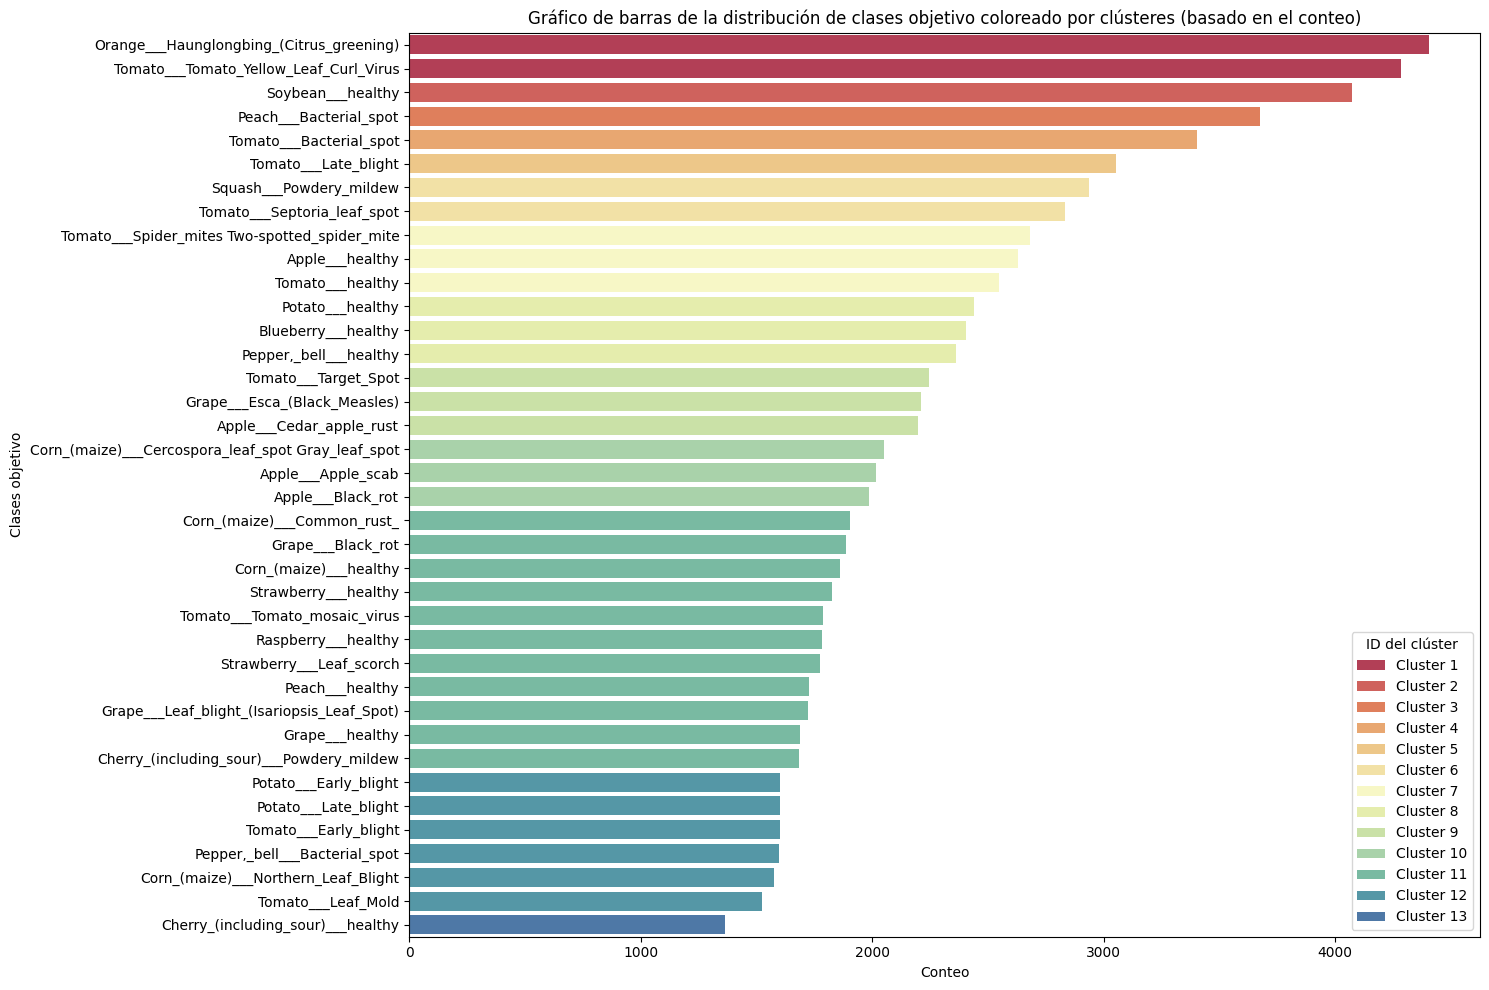

In [45]:
# Se define el feature a partir del cual se aplicarán las aumentaciones
#target = 'class' # class / group
data = processed_split.copy()
found_clusters = find_clusters(data[target])
plot_clusters(data, target, found_clusters)

## Merge dataframes

In [46]:
# MERGE DEL DATAFRAME AUMENTADO CON EL ORIGINAL
# 1. Se pararan los datos de archivos procesados
for_update = processed_split[processed_split['is_original']==True]
new_rows = processed_split[processed_split['is_original']==False]

# 2. Se actualiza el Dataframe original con los nuevos valores
df_split.update(for_update)

# 3. Se agregan las aumentaciones con el dataframe original
df_augmented = pd.concat([df_split, new_rows], axis=0)
df_augmented.update(for_update)

# 4. Ajuste de formato
df_augmented['ref'] = df_augmented['ref'].astype('Int64')

# 5. Eliminación de posibles entrads duplicadas
df_augmented.drop_duplicates(subset='filename', keep='first', inplace=True)

# 6. (Opcional) Reordenar por índice si querés mantener orden
# df_merged = df_merged.sort_index()

In [47]:
df_augmented.head()

,image_path,filename,class,group,tag,split,augmented,is_original,ref
0,Strawberry___healthy/,8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,True,True,0
1,Strawberry___healthy/,abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,False,True,2
2,Strawberry___healthy/,d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2...,Strawberry___healthy,Strawberry,healthy,train,True,True,3
3,Strawberry___healthy/,3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,True,True,4
4,Strawberry___healthy/,4005fb13-0d7c-4a30-9ee3-73e9e4cee05e___RS_HL 1...,Strawberry___healthy,Strawberry,healthy,train,True,True,5


# Undersampling

In [48]:
counts = df_augmented[target].value_counts()
undersample_works = []
undersample_count = 0
undersample_count_group = 0

for i, process in enumerate(estrategy):
    if process.get('limit'):
        print(f"{numoji(i+1)} Se aplicará submuestreo hasta {process['limit']} imágenes para las siguientes clases:")
        for clase in process['classes']:
            print(f" - {clase}: {counts[clase]} -> {process['limit']}")
            if counts[clase] > process['limit']:
                undersample_count_group += counts[clase] - process['limit']
            else:
                print(f"    ‼️ La clase '{clase}' posee {counts[clase]} imágenes, por lo que no es necesario aplicar submuestreo.")
        if undersample_count_group > 0:
            print("Reducción para el grupo: ",undersample_count_group)
            undersample_count += undersample_count_group
            undersample_works.append(process)
        else:
            print("    🚨 CUIDADO: Aunque está configurado un proceso de undersampling, la cantidad de muestras para estas clases es menor al límite establecido.")
        print()
if undersample_count:
    print(f"✅ Luego del proceso de undersampling se eliminarán un total de {undersample_count} imágenes.")
else:
    print(f"🌟 No se ha configurado ningún proceso de undersampling para la estrategia seleccionada.")

1️⃣ Se aplicará submuestreo hasta 2000 imágenes para las siguientes clases:
 - Orange___Haunglongbing_(Citrus_greening): 4405 -> 2000
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 -> 2000
 - Soybean___healthy: 5090 -> 2000
Reducción para el grupo:  7781

2️⃣ Se aplicará submuestreo hasta 2000 imágenes para las siguientes clases:
 - Peach___Bacterial_spot: 3674 -> 2000
 - Tomato___Bacterial_spot: 3404 -> 2000
 - Tomato___Late_blight: 3054 -> 2000
 - Squash___Powdery_mildew: 3286 -> 2000
 - Tomato___Septoria_leaf_spot: 2834 -> 2000
 - Tomato___Spider_mites Two-spotted_spider_mite: 2682 -> 2000
 - Apple___healthy: 2961 -> 2000
 - Tomato___healthy: 2546 -> 2000
 - Blueberry___healthy: 2404 -> 2000
 - Pepper,_bell___healthy: 2364 -> 2000
 - Tomato___Target_Spot: 2246 -> 2000
 - Grape___Esca_(Black_Measles): 2212 -> 2000
Reducción para el grupo:  17448

✅ Luego del proceso de undersampling se eliminarán un total de 25229 imágenes.


In [49]:
# PROCESAMIENTO DE UNDERSAMPLING CON FILTRADO POR CLASE
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SETUP INCIAL:
#verbose = True # Incluye detalle del proceso y estimación de tiempo
testing = False # No modifica archivos
debugging = False # Incluye detalle de archivos y mensajes de error
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
undersample_split = df_augmented[df_augmented['split']=='train']
undersample_split['for_remove'] = False
spacer1 = '    '
spacer2 = '      '
remove_data_work = pd.DataFrame(columns=undersample_split.columns)
indices_to_remove_all = []

for i, work in enumerate(undersample_works):
    print(f'{numoji(i+1)} Iniciando trabajo de submuestreo para {len(work)} clases:')
    limit = work['limit']
    print(f' · Límite establecido para undersampling: {limit}\n')

    for clase in work['classes']:
        indices_to_remove_class = []
        class_indices = undersample_split[undersample_split['class'] == clase].index

        removing_message = lambda remove_data: f"{spacer1}> Serán eliminadas: {len(remove_data)} imágenes"
        data = undersample_split.loc[class_indices]
        data_orig = data[data['is_original'] == True]
        data_aug = data[data['is_original'] == False]
        print(f'  - {clase}: contiene {len(data)} imágenes ({len(data_orig)}+{len(data_aug)})')

        if len(data_orig) > limit:
            print(f"{spacer1}Data original supera el límite") if debugging else None
            print(removing_message(data_orig.iloc[limit:]))
            remove_orig_indices = data_orig.index[limit:].tolist()
            indices_to_remove_class.extend(remove_orig_indices)
            if len(data_aug) != 0:
                # Verifica que no se hayan generado aumentaciones inncesarias
                # En caso afirmativo, las elimina también
                remove_aug_indices = data_aug.index.tolist()
                indices_to_remove_class.extend(remove_aug_indices)
        elif len(data_aug) > limit:
            print(f"{spacer1}Data aumentada supera el límite") if debugging else None
            print(removing_message(data_aug.iloc[limit:]))
            remove_orig_indices = data_aug.index[limit:].tolist()
            indices_to_remove_class.extend(remove_orig_indices)
        elif len(data_orig)+len(data_aug) > limit:
            print(f"{spacer1}Al unir ambos conjuntos se supera el límite") if debugging else None
            keep_aug_count = limit - len(data_orig)
            print(f"{spacer1}Se deben incluir", keep_aug_count) if debugging else None
            print(removing_message(data_aug.iloc[keep_aug_count:]))
            remove_aug_indices = data_aug.index[keep_aug_count:].tolist()
            indices_to_remove_class.extend(remove_aug_indices)
        else:
            print(f"No es necesario aplicar undersampling. La cantidad de imágenes {len(data)} no supera el límite establecido.")

        if indices_to_remove_class:
             print(f"{spacer1}Total marcado para remover en clase '{clase}': {len(indices_to_remove_class)}") if debugging else None
             indices_to_remove_all.extend(indices_to_remove_class)
    print()

#====================================================================================================
# --- Post-procesamiento después de iterar a través de todos los trabajos ---
# Elimina duplicados entre diferentes trabajos/clases
indices_to_remove_all = list(set(indices_to_remove_all))
print(f"Total de imágenes marcadas para eliminación: {len(indices_to_remove_all)}")
print("¿Deseas iniciar el procesamiento?\n\n")
time.sleep(1) # Para asegurar que se muestren los prints

# Input de confirmación del usuario
confirmacion = input(f"⚠️ ATENCIÓN: El proceso puede demorar varios minutos. Se requiere confirmación para continuar [Y/N]: ").strip().lower()
if confirmacion != 'y':
    print(f"\n⛔️ La ejecución ha sido denegada por el usuario.")
else:

    folder = f'{AUG_PATH}train/'
    error_log = []
    # --- Aplica los cambios al DataFrame principal ---
    print("🔄 INICIANDO PROCESO DE ELIMINACIÓN (para interrumpir presione: Ctrl+Q)")
    if not testing and indices_to_remove_all:  # Solo modifica si no está en modo de prueba y hay índices
        print(f"Actualizando el dataframe...")
        time.sleep(5) # Pausa por precaución para que el usuario pueda interrumpir
        undersample_split.loc[indices_to_remove_all, 'for_remove'] = True
        print("¡Actualización del dataframe completada!") if debugging else None
    elif testing:
        show_test_mode_alert(spacer1)
    else:
        print("‼️ No se encontraron filas marcadas para eliminación. [ERROR 1]")


    # --- Crea el DataFrame final de filas marcadas para eliminación ---
    print("Preparando archivos para su eliminación...")
    remove_data_work = undersample_split[undersample_split['for_remove'] == True].copy()
    deleted_count = 0
    not_found_count = 0
    error_count = 0
    alert_counter = 0

    # Verificar si las columnas requeridas existen antes de iterar
    required_cols = ['filename', 'image_path']
    if not all(col in remove_data_work.columns for col in required_cols):
        print(f"❌ ERROR: El DataFrame 'remove_data_work' no contiene las columnas requeridas: {required_cols}")
        raise ValueError
    else:

        # Iterar a través de las filas del DataFrame
        for index, row in remove_data_work.iterrows():
            try:
                # Extraer el nombre del archivo y la ruta del directorio de la fila
                # Usar str() para manejar posibles tipos no cadena de manera segura, aunque deberían ser cadenas
                filename = str(row['filename'])
                image_dir = str(row['image_path'])

                # Verificación básica para valores vacíos/invalidos
                if not filename or not image_dir or pd.isna(row['filename']) or pd.isna(row['image_path']):
                    print(f"  ❗️ Fila {index} omitida - 'filename' o 'image_path' inválido/vacío (Filename: '{filename}', Path: '{image_dir}')")
                    error_count += 1
                    continue  # Saltar a la siguiente fila

                # Construir la ruta completa al archivo
                full_file_path = os.path.join(folder, image_dir, filename)

                # Verificar si el archivo existe antes de intentar eliminarlo
                if os.path.exists(full_file_path):
                    os.remove(full_file_path) if not testing else None
                    if debugging & (index % 1000 == 0):
                        print(f"{spacer2}⚠️ Muestra ejemplos de archivos eliminados (cada 1000 outputs)") if alert_counter % 50 == 0 else None
                        print(f"{spacer2}🔹 ELIMINADO: {filename}")
                        alert_counter += 1
                    deleted_count += 1
                else:
                    # La ruta del archivo derivada del DataFrame no existe
                    print(f"{spacer2}🔸 NO ENCONTRADO: {filename}") if debugging else None
                    error_log.append((folder, image_dir, filename, full_file_path))
                    not_found_count += 1

            except OSError as e:
                # Manejar posibles errores del sistema operativo durante la eliminación (por ejemplo, permisos)
                print(f"{spacer2}❗️ ERROR eliminando {full_file_path}: {e}")
                error_count += 1
                continue
            except KeyError as e:
                # Manejar el caso donde la columna 'filename' o 'image_path' no existe (debería ser detectado antes)
                print(f"{spacer2}❗️ ERROR: Falta la columna {e} en la fila {index}.")
                error_count += 1
                continue
            except Exception as e:
                # Capturar cualquier otro error inesperado para esta fila
                print(f"{spacer2}❗️ ERROR INESPERADO procesando la fila {index} ({full_file_path}): {e}")
                error_count += 1
                continue

    work_done = len(remove_data_work)
    undersampled_split = undersample_split[undersample_split['for_remove'] == False].copy()
    pending_for_undersample = undersample_split[undersample_split['for_remove'] == True].copy()
    if debugging or not_found_count or error_count:
        print("\n--- Resumen de Eliminación ---")
        print(f"Archivos eliminados exitosamente: {deleted_count}")
        print(f"Archivos no encontrados en la ruta especificada: {not_found_count}")
        print(f"Errores durante el proceso: {error_count}")
        print(f"Total de filas procesadas: {work_done}")
        print("-----------------------------")

    if error_count:
        print(f"\n{spacer1}‼️ ERROR: No se pudo completar la eliminación para {error_count} archivos", "[Activar opción 'debugging' para más detalle]" if not debugging else None)
    elif not_found_count:
        print("\n‼️ No se encontraron archivos indicados para eliminación. [ERROR 2]", "[Activar opción 'debugging' para más detalle]" if not debugging else None)
    else:
        # Se crea el conjunto de datos submuestreado final:
        if work_done != deleted_count:
            print("\n‼️ La cantidad de archivos para eliminar y efectivamente eliminados no coincide.")
            if debugging:
                print("Debían removerse:",len(indices_to_remove_all))
                print("Se procesaron:", deleted_count)
                print("Se registraron en el dataframe:",len(undersampled_split))
        else:
            print("\n✅ Eliminación de archivos completada exitosamente.")
        print(f"El conjunto de datos submuestreado final tiene {len(df_augmented)} imágenes.")

1️⃣ Iniciando trabajo de submuestreo para 3 clases:
 · Límite establecido para undersampling: 2000

  - Orange___Haunglongbing_(Citrus_greening): contiene 4405 imágenes (4405+0)
    > Serán eliminadas: 2405 imágenes
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: contiene 4286 imágenes (4286+0)
    > Serán eliminadas: 2286 imágenes
  - Soybean___healthy: contiene 4072 imágenes (4072+0)
    > Serán eliminadas: 2072 imágenes

2️⃣ Iniciando trabajo de submuestreo para 3 clases:
 · Límite establecido para undersampling: 2000

  - Peach___Bacterial_spot: contiene 3674 imágenes (1837+1837)
    > Serán eliminadas: 1674 imágenes
  - Tomato___Bacterial_spot: contiene 3404 imágenes (1702+1702)
    > Serán eliminadas: 1404 imágenes
  - Tomato___Late_blight: contiene 3054 imágenes (1527+1527)
    > Serán eliminadas: 1054 imágenes
  - Squash___Powdery_mildew: contiene 2936 imágenes (1468+1468)
    > Serán eliminadas: 936 imágenes
  - Tomato___Septoria_leaf_spot: contiene 2834 imágenes (1417+1417)
    >

<ipython-input-49-0ced91b2f48d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undersample_split['for_remove'] = False


⚠️ ATENCIÓN: El proceso puede demorar varios minutos. Se requiere confirmación para continuar [Y/N]: y
🔄 INICIANDO PROCESO DE ELIMINACIÓN (para interrumpir presione: Ctrl+Q)
Actualizando el dataframe...
Preparando archivos para su eliminación...

✅ Eliminación de archivos completada exitosamente.
El conjunto de datos submuestreado final tiene 89129 imágenes.


## Verificación

In [50]:
print(f'Quedaron {len(error_log)} sin eliminar')

Quedaron 0 sin eliminar


In [51]:
# Verificación de entradas duplicadas
filename_counts = df_augmented['filename'].value_counts()
filename_counts.head()

,count
filename,
8665efd2-fa3d-45f8-b1c0-746c99fb7d1e___RS_HL 1924-096261.JPG,1
8f558908-aa1b-4a86-855a-5094c2392e5a___RS_HL 1973.JPG,1
abdd34a0-ab02-41e0-95a3-a014ab863ec2___RS_HL 1757.JPG,1
d1aee44a-b6bb-45b9-b7b6-5d553add8fd1___RS_HL 2163.JPG,1
3d28c3ea-8419-4e09-addd-211e3828e39f___RS_HL 1942.JPG,1


In [52]:
for log in error_log:
    if filename_counts.loc[log[2]]-1:
        pass
    else:
        print(False)
        print(log)

In [53]:
error_log[-10:]

[]

Clústeres identificados:
 · Multiplicador Desviación Estándar 0.15

Clúster 1:
  (Rango de conteo: 2440 - 2440)
  - Potato___healthy: 2440

Clúster 2:
  (Rango de conteo: 2200 - 2200)
  - Apple___Cedar_apple_rust: 2200

Clúster 3:
  (Rango de conteo: 1988 - 2049)
  - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 2049
  - Apple___Apple_scab: 2016
  - Tomato___Target_Spot: 2000
  - Blueberry___healthy: 2000
  - Tomato___Septoria_leaf_spot: 2000
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 2000
  - Squash___Powdery_mildew: 2000
  - Peach___Bacterial_spot: 2000
  - Tomato___Bacterial_spot: 2000
  - Tomato___Late_blight: 2000
  - Orange___Haunglongbing_(Citrus_greening): 2000
  - Pepper,_bell___healthy: 2000
  - Tomato___Spider_mites Two-spotted_spider_mite: 2000
  - Grape___Esca_(Black_Measles): 2000
  - Apple___healthy: 2000
  - Soybean___healthy: 2000
  - Tomato___healthy: 2000
  - Apple___Black_rot: 1988

Clúster 4:
  (Rango de conteo: 1825 - 1906)
  - Corn_(maize)___Common_rust_: 

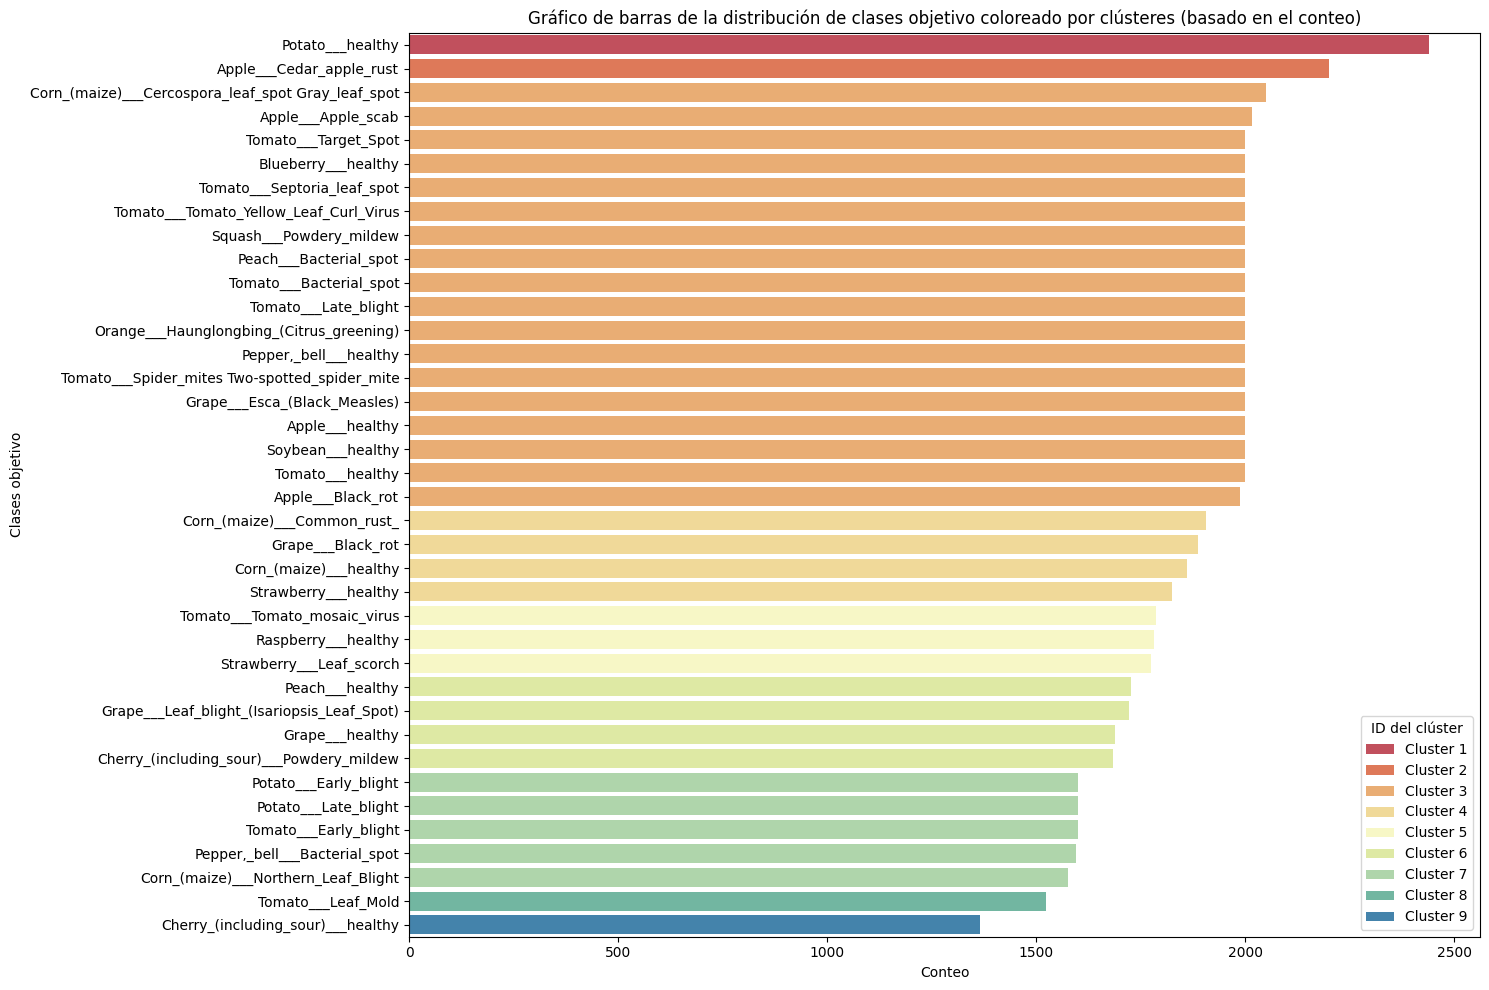

In [54]:
# Se  verifica la distribucion
data = undersampled_split.copy()
found_clusters = find_clusters(data[target])
plot_clusters(data, target, found_clusters)

In [55]:
undersampled_split[undersampled_split['for_remove']==True]

,image_path,filename,class,group,tag,split,augmented,is_original,ref,for_remove


In [56]:
del undersampled_split['for_remove']

In [57]:
# MERGE DEL DATAFRAME REDUCIDO CON EL AUMENTADO
# 1. Obtén las filas de df_augmented donde 'split' NO sea 'train'
df_non_train = df_augmented[df_augmented['split'] != 'train'].copy()

# 2. Combina ambos dataframes
df_undersampled = pd.concat([df_non_train, undersampled_split])

# Opcional: Restablece el índice del nuevo dataframe para un índice limpio y secuencial
#df_undersampled = df_undersampled.reset_index(drop=True)

## Distribución por clase

In [58]:
### Resumen distribucion por grupo
print(f"Conteo por {target}:")
print(df_undersampled[target].value_counts())

Conteo por class:
class
Soybean___healthy                                     3018
Potato___healthy                                      2470
Squash___Powdery_mildew                               2350
Apple___healthy                                       2329
Apple___Cedar_apple_rust                              2200
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    2152
Apple___Black_rot                                     2112
Apple___Apple_scab                                    2016
Grape___Esca_(Black_Measles)                          2000
Blueberry___healthy                                   2000
Pepper,_bell___healthy                                2000
Orange___Haunglongbing_(Citrus_greening)              2000
Tomato___Target_Spot                                  2000
Tomato___Late_blight                                  2000
Tomato___Bacterial_spot                               2000
Tomato___Tomato_Yellow_Leaf_Curl_Virus                2000
Peach___Bacterial_spot          

In [59]:
print("Efecto de la aumentación de datos por clase:\n")
counts_entrada = df_split[target].value_counts()
counts_salida = df_undersampled[target].value_counts()

classes = counts_salida.index
for class_ in classes:
    prop = counts_salida[class_]/counts_entrada[class_]
    print(f" - {class_}: {counts_entrada[class_]} -> {counts_salida[class_]} ({'+' if prop >1 else ''}{(prop-1)*100:.0f}%)")

Efecto de la aumentación de datos por clase:

 - Soybean___healthy: 9162 -> 3018 (-67%)
 - Potato___healthy: 274 -> 2470 (+801%)
 - Squash___Powdery_mildew: 3199 -> 2350 (-27%)
 - Apple___healthy: 2961 -> 2329 (-21%)
 - Apple___Cedar_apple_rust: 220 -> 2200 (+900%)
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 923 -> 2152 (+133%)
 - Apple___Black_rot: 1118 -> 2112 (+89%)
 - Apple___Apple_scab: 504 -> 2016 (+300%)
 - Grape___Esca_(Black_Measles): 1106 -> 2000 (+81%)
 - Blueberry___healthy: 1202 -> 2000 (+66%)
 - Pepper,_bell___healthy: 1182 -> 2000 (+69%)
 - Orange___Haunglongbing_(Citrus_greening): 4405 -> 2000 (-55%)
 - Tomato___Target_Spot: 1123 -> 2000 (+78%)
 - Tomato___Late_blight: 1527 -> 2000 (+31%)
 - Tomato___Bacterial_spot: 1702 -> 2000 (+18%)
 - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 -> 2000 (-53%)
 - Peach___Bacterial_spot: 1837 -> 2000 (+9%)
 - Tomato___Spider_mites Two-spotted_spider_mite: 1341 -> 2000 (+49%)
 - Tomato___Septoria_leaf_spot: 1417 -> 2000 (+4

Clústeres identificados:
 · Multiplicador Desviación Estándar 0.15

Clúster 1:
  (Rango de conteo: 3018 - 3018)
  - Soybean___healthy: 3018

Clúster 2:
  (Rango de conteo: 2470 - 2470)
  - Potato___healthy: 2470

Clúster 3:
  (Rango de conteo: 2329 - 2350)
  - Squash___Powdery_mildew: 2350
  - Apple___healthy: 2329

Clúster 4:
  (Rango de conteo: 2112 - 2200)
  - Apple___Cedar_apple_rust: 2200
  - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 2152
  - Apple___Black_rot: 2112

Clúster 5:
  (Rango de conteo: 1996 - 2016)
  - Apple___Apple_scab: 2016
  - Grape___Esca_(Black_Measles): 2000
  - Blueberry___healthy: 2000
  - Pepper,_bell___healthy: 2000
  - Orange___Haunglongbing_(Citrus_greening): 2000
  - Tomato___Target_Spot: 2000
  - Tomato___Late_blight: 2000
  - Tomato___Bacterial_spot: 2000
  - Tomato___Tomato_Yellow_Leaf_Curl_Virus: 2000
  - Peach___Bacterial_spot: 2000
  - Tomato___Spider_mites Two-spotted_spider_mite: 2000
  - Tomato___Septoria_leaf_spot: 2000
  - Tomato___he

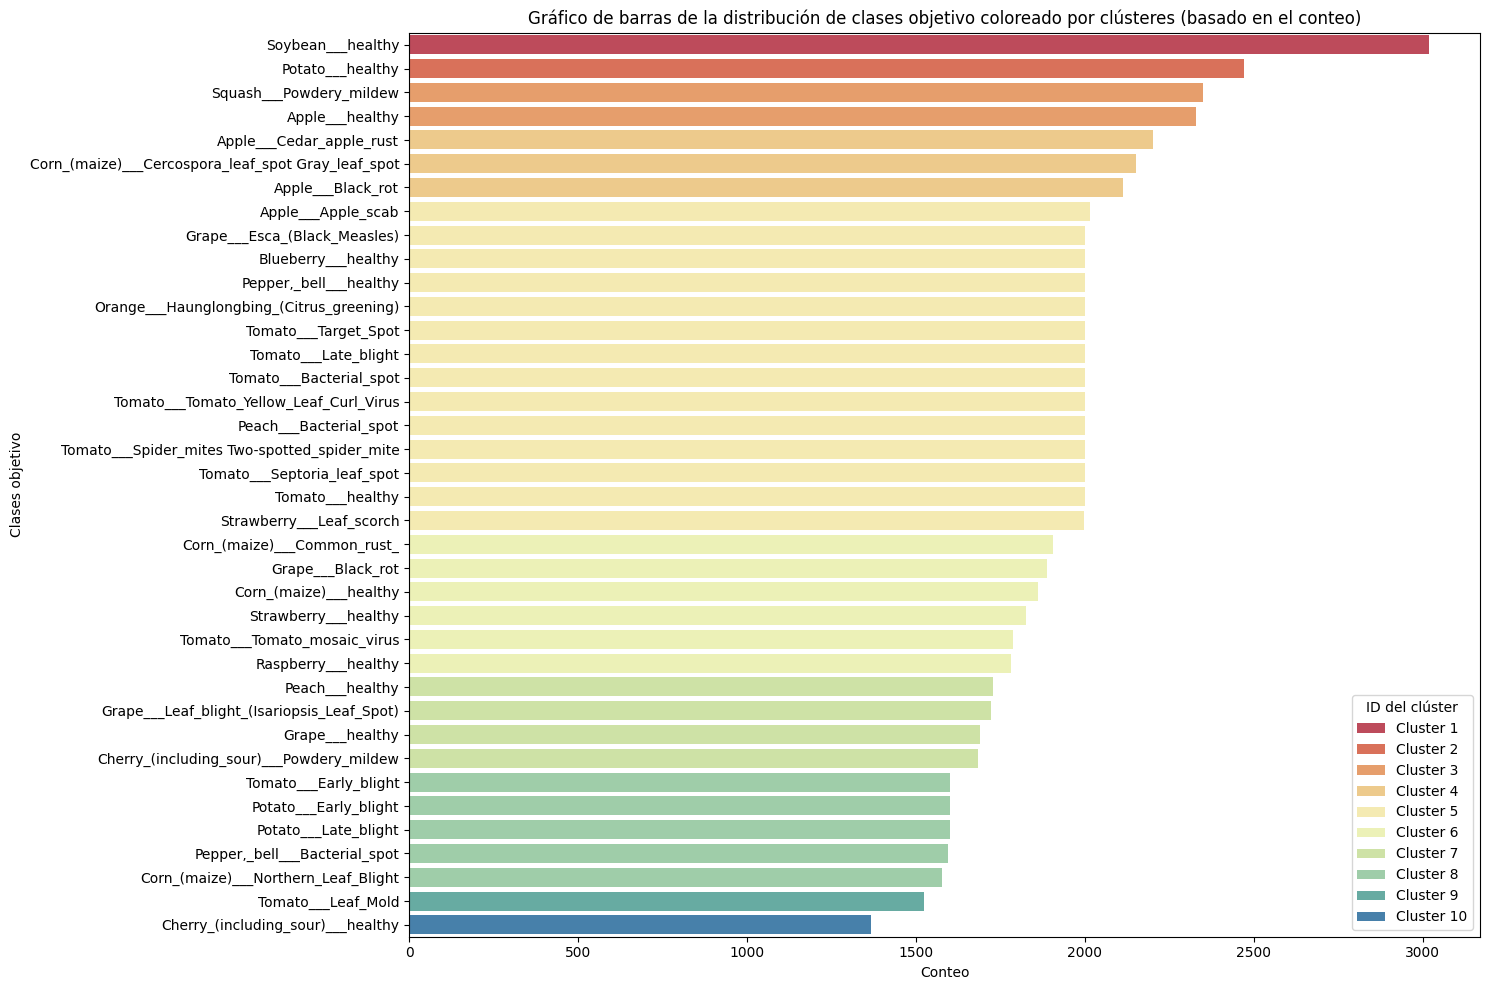

In [60]:
# Se  verifica la distribucion
data = df_undersampled.copy()
found_clusters = find_clusters(data[target])
plot_clusters(data, target, found_clusters)

----
# Training model

## Dataloader

In [61]:
import tensorflow as tf

In [62]:
# Data laoders setup
def load_from_directory(data_folder):
    """
    Carga un dataset de imágenes desde un directorio específico.

    Args:
        data_folder (str): Ruta al directorio que contiene las imágenes.

    Returns:
        tf.data.Dataset: Dataset de TensorFlow con las imágenes y etiquetas.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_folder,  # Ruta al directorio de datos
        labels="inferred",  # Las etiquetas se infieren automáticamente desde los nombres de las carpetas
        label_mode="categorical",  # Las etiquetas se codifican como categorías (one-hot encoding)
        class_names=None,  # Las clases se detectan automáticamente
        color_mode="rgb",  # Las imágenes se cargan en modo RGB
        batch_size=128,  # Tamaño de lote para el entrenamiento
        image_size=(256, 256),  # Redimensiona las imágenes a 128x128 píxeles
        shuffle=True,  # Mezcla las imágenes aleatoriamente
        seed=42,  # No se utiliza una semilla específica para la aleatorización
        validation_split=None,  # No se realiza una división de validación aquí
        subset=None,  # No se especifica un subconjunto (train/validation)
        interpolation="bilinear",  # Método de interpolación para redimensionar las imágenes
        follow_links=False,  # No sigue enlaces simbólicos
        crop_to_aspect_ratio=False  # No recorta las imágenes para ajustar la relación de aspecto
    )

    return dataset

In [63]:
# Carga el dataset de imágenes desde el directorio especificado
train_images = ""; test_images = ""; valid_images = ""

print("Cargando datasets desde el directorio…\n")
for split in splits:
    data_folder = f'{SPLITTED_PATH}{split}/'

    # Carga el conjunto de datos desde el directorio especificado
    # Utiliza la función de TensorFlow para crear un dataset de imágenes
    match split:
        case 'train':
            print(f"Cargando dataset de entrenamiento desde:\n > {data_folder}")
            train_images = load_from_directory(data_folder)
        case 'test':
            print(f"Cargando dataset de test desde:\n > {data_folder}")
            test_images = load_from_directory(data_folder)
        case 'valid':
            print(f"Cargando dataset de validación desde:\n > {data_folder}")
            valid_images = load_from_directory(data_folder)
        case _: # En caso de no coincidir con ninguno de los splits
            print(f"⚠️ El split '{split}' no es reconocido. No se cargará ningún dataset.")
            continue # Salta al siguiente split
    print(f"✅ Dataset cargado exitosamente.\n")

Cargando datasets desde el directorio…

Cargando dataset de entrenamiento desde:
 > Nonetrain/
Found 71202 files belonging to 38 classes.
✅ Dataset cargado exitosamente.

Cargando dataset de test desde:
 > Nonetest/
Found 10861 files belonging to 38 classes.
✅ Dataset cargado exitosamente.



In [64]:
print("Resumen de los datasets cargados:")
print(f" - Total de imágenes en el dataset de entrenamiento: {len(train_images)}")
print(f" - Total de imágenes en el dataset de validación: {len(valid_images)}")
print(f" - Total de imágenes en el dataset de test: {len(test_images)}")
print(f"Total de imágenes cargadas: {len(train_images) + len(test_images) + len(valid_images)}\n")

Resumen de los datasets cargados:
 - Total de imágenes en el dataset de entrenamiento: 557
 - Total de imágenes en el dataset de validación: 0
 - Total de imágenes en el dataset de test: 85
Total de imágenes cargadas: 642



In [65]:
print(f"Clases detectadas:")
[print(" -",clase) for clase in train_images.class_names]
print(f"Total de clases: {len(train_images.class_names)}")

Clases detectadas:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
 - Corn_(maize)___healthy
 - Grape___Black_rot
 - Grape___Esca_(Black_Measles)
 - Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
 - Grape___healthy
 - Orange___Haunglongbing_(Citrus_greening)
 - Peach___Bacterial_spot
 - Peach___healthy
 - Pepper,_bell___Bacterial_spot
 - Pepper,_bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Raspberry___healthy
 - Soybean___healthy
 - Squash___Powdery_mildew
 - Strawberry___Leaf_scorch
 - Strawberry___healthy
 - Tomato___Bacterial_spot
 - Tomato___Early_blight
 - Tomato___Late_blight
 - Tomato___Leaf_Mold
 - Tomato___Septoria_leaf_spot
 - Tomato___Spider_mites Two-spotted_spider_mite
 

----
## Arquitectura del modelo

In [66]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Input

model = models.Sequential()

# Bloque 1
model.add(Input(shape=(256, 256, 3)))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Bloque 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())

# Capa densa intermedia
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.25))

# Capa de salida con 38 neuronas y softmax para multiclase
model.add(layers.Dense(38, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,102,502 (99.57 MB)

 Trainable params: 26,100,518 (99.57 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Entrenamiento

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint

start_time = time.perf_counter()

# Definimos el callback para guardar el mejor modelo según la métrica elegida
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',   # Se generará una carpeta con este nombre
    monitor='val_loss',            # Métrica a monitorear ('val_accuracy' es otra opción)
    save_best_only=True,           # Guarda solo si hay mejora
    save_weights_only=False,       # Guarda la arquitectura + pesos
    verbose=1
)

# Ajusta el modelo a tu criterio
with tf.device('/GPU:0'):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs=10,
    callbacks=[checkpoint_callback]  # Incorporamos el callback
)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4875 - loss: 2.0256
Epoch 1: val_loss improved from inf to 1.54267, saving model to best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 231s 363ms/step - accuracy: 0.4877 - loss: 2.0244 - val_accuracy: 0.5738 - val_loss: 1.5427
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8281 - loss: 0.5694
Epoch 2: val_loss improved from 1.54267 to 0.24799, saving model to best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 212s 317ms/step - accuracy: 0.8281 - loss: 0.5692 - val_accuracy: 0.9204 - val_loss: 0.2480
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8996 - loss: 0.3193
Epoch 3: val_loss did not improve from 0.24799
557/557 ━━━━━━━━━━━━━━━━━━━━ 201s 315ms/step - accuracy: 0.8996 - loss: 0.3192 - val_accuracy: 0.9052 - val_loss: 0.3011
Epoch 4/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9366 - loss: 0.1995
Epoch 4: val_loss improved from 0.24799 to 0.16919, saving model to best

In [68]:
print(f"El entrenamiento tomó {elapsed_time:.2f} segundos")

El entrenamiento tomó 2009.19 segundos


## Guardando resultados

In [69]:
#Recording History in json & pickle
import json
with open('training_hist.json','w') as f:
  json.dump(history.history,f)

import pickle
with open('training_hist.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [73]:
import os

experiment = 'experimento_a2' # Completar número de experimento
files = ['best_model.keras','training_hist.json','training_hist.pkl']
destino=f"/content/drive/MyDrive/CV2-PlantVillage/{experiment}/"

def check_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' created successfully.")
    else:
        print(f"Folder '{folder}' already exists.")

check_folder(destino)

for file in files:
    try:
        origen=f"/content/{file}"
        !cp -r "$origen" "$destino"
    except:
        print(f"Error al copiar el archivo '{file}'")
    finally:
        print(f"Archivo '{file}' copiado exitosamente.")

Folder '/content/drive/MyDrive/CV2-PlantVillage/experimento_a2/' created successfully.
Archivo 'best_model.keras' copiado exitosamente.
Archivo 'training_hist.json' copiado exitosamente.
Archivo 'training_hist.pkl' copiado exitosamente.


---
# Gráficos

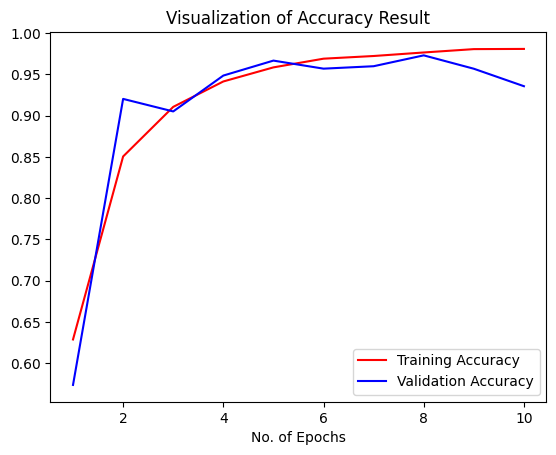

In [71]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1,11)]
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [72]:
#Validation set Accuracy
model = tf.keras.models.load_model('best_model.keras')
val_loss, val_acc = model.evaluate(test_images)
print('Validation accuracy:', val_acc)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.9740 - loss: 0.0931
Validation accuracy: 0.9731147885322571
